## Imports

In [16]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import importlib
importlib.reload(trainers)

sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

## states and actions names

In [33]:
state_names = {
    "HalfCheetah": [
        r"$rootz$",
        r"$rooty$",
        r"$bthigh$",
        r"$bshin$",
        r"$bfoot$",
        r"$fthigh$",
        r"$fshin$",
        r"$ffoot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{bthigh}$",
        r"$\dot{bshin}$",
        r"$\dot{bfoot}$",
        r"$\dot{fthigh}$",
        r"$\dot{fshin}$",
        r"$\dot{ffoot}$",
    ],
    "Hopper": [
        r"$rootz$",
        r"$rooty$",
        r"$thigh$",
        r"$leg$",
        r"$foot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{thigh}$",
        r"$\dot{leg}$",
        r"$\dot{foot}$",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ]
}

action_names = {
    "HalfCheetah": [
        r"$t\_bthigh$",
        r"$t\_bshin$",
        r"$t\_bfoot$",
        r"$t\_fthigh$",
        r"$t\_fshin$",
        r"$t\_ffoot$",
    ],
    "Hopper": [
        r"$t\_thigh$",
        r"$t\_leg$",
        r"$t\_foot$",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ]
}

# Helpers

## load model and tokenizer

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="cuda:7",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

finish loading tokenizer
finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

## policy classes

In [8]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [9]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Generate data

## load env, actor, data

In [64]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
if 'obs_reward' in X.columns:
    X = X.drop(['obs_reward'], axis=1)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions  # +1 for halfcheetah
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]
episode_starts

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000])

In [65]:
only_use_context = False

context_length = 500
rescale_factor = 7.0
up_shift = 1.5

episode = 16

init_index = episode_starts[episode]

# Scaling pipeline: minmax + standard

<Figure size 640x480 with 0 Axes>

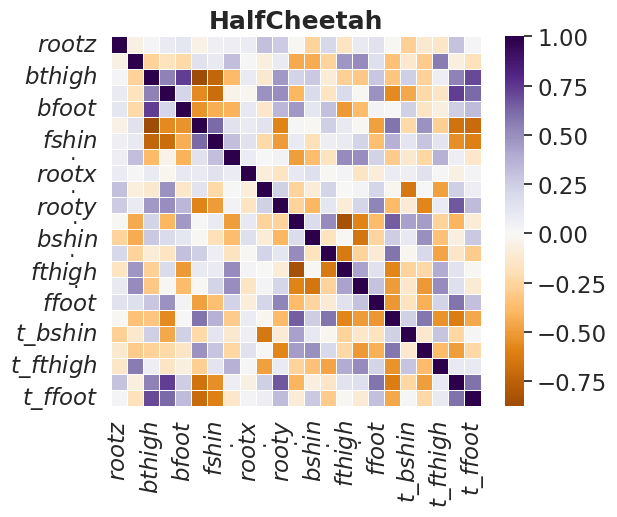

In [66]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

n_original_components = n_observations + n_actions
obs = X[:, :n_original_components] if not only_use_context else X[init_index:init_index+context_length, :n_original_components]
obs = obs[~np.isnan(obs[:,-1])]

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(obs)
obs_scaled = scaling_pipeline.transform(obs)

columns = copy.copy(state_names[env_name])
if n_original_components == n_observations + n_actions:
    columns += action_names[env_name]

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=columns, columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    # ax.text(x=0, y=1, s='test')
    ax.set_title(env_name, fontweight="bold")

# PCA

explained var: [0.274 0.492 0.614 0.715 0.766 0.804 0.836 0.862 0.883 0.904 0.921 0.935
 0.947 0.958 0.967 0.975 0.981 0.986 0.99  0.993 0.995 0.996 0.997]
singular_values: [345.94373327 308.26778069 230.67006861 209.86704742 149.50028428
 128.75128351 118.64196348 107.24164125  96.85604347  95.62602094
  86.54569439  78.82186774  73.33950625  68.05802353  62.27823556
  60.24848594  52.9945315   47.97606373  43.81683653  35.81402262
  30.91830235  23.55737912  23.00117489]


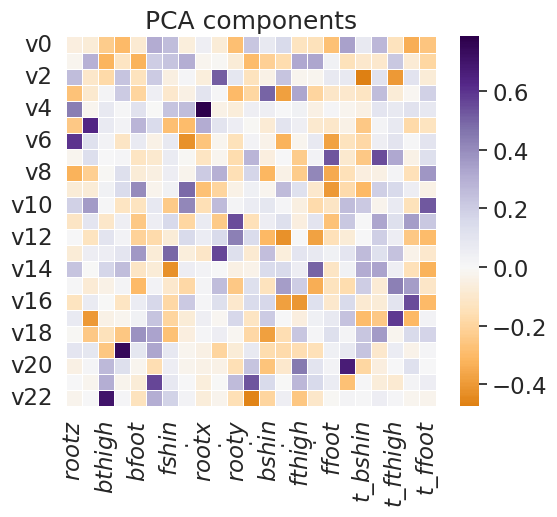

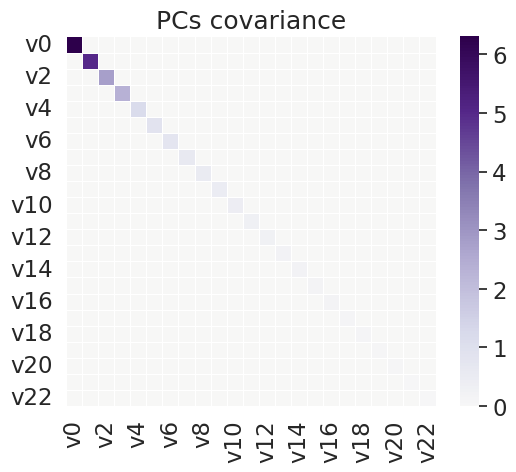

In [67]:
# pca
n_components = n_observations + n_actions
# pca = FastICA(n_components=n_components)  # PCA
pca = PCA(n_components=n_components)
pca.fit(obs_scaled)

print(f"explained var: {pca.explained_variance_ratio_.round(3).cumsum()}")
print(f"singular_values: {pca.singular_values_}")

df = pd.DataFrame(pca.components_, index=[f'v{i}' for i in range(n_components)], columns=columns)
with sns.axes_style("white"):
    plt.figure()
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('PCA components')

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(pca.transform(obs_scaled), rowvar=False), index=[f'v{i}' for i in range(n_components)], columns=[f'v{i}' for i in range(n_components)])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('PCs covariance')

# with sns.axes_style("white"):
#     ax = sns.heatmap(pca.get_covariance(), linewidth=0.5, square=True,  cmap="YlGnBu")

plt.show()

time_series = pca.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))

# ICA

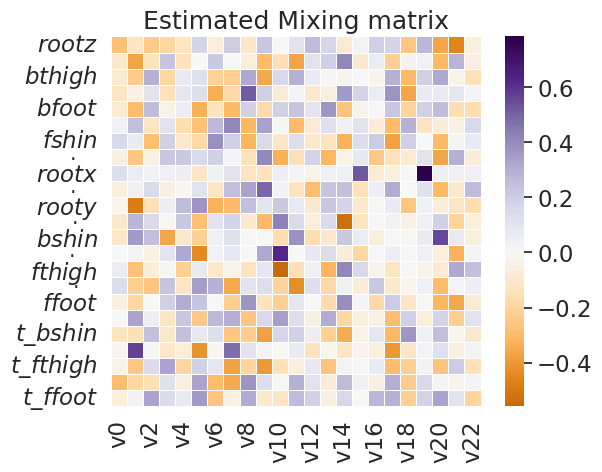

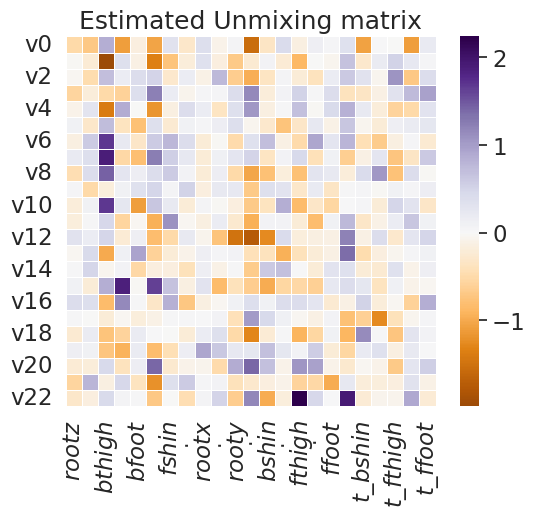

In [68]:
# pca
n_components = n_observations + n_actions
ica = FastICA(n_components=n_components)  # PCA
ica.fit(obs_scaled)

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(ica.mixing_, index=columns, columns=[f'v{i}' for i in range(n_components)])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Estimated Mixing matrix')

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(ica.components_, index=[f'v{i}' for i in range(n_components)], columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Estimated Unmixing matrix')
    
plt.show()

time_series = ica.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))

# Identity

In [46]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return input_array * 1

    def inverse_transform(self, input_array, y=None):
        return input_array * 1

n_components = n_observations

identity = IdentityTransformer()

# time_series = identity.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_observations]))
time_series = identity.transform(X[init_index:init_index+context_length, :n_observations])
time_series.shape

(500, 18)

## paper plot

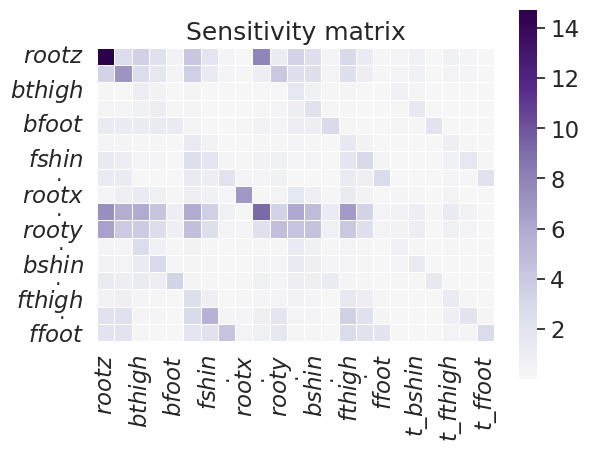

In [69]:
# load SA
with open(f'/mnt/vdb/abenechehab/icl_paper/sa_{env_name}_expert_action.npy', 'rb') as f:
    sa_action = np.load(f)
with open(f'/mnt/vdb/abenechehab/icl_paper/sa_{env_name}_expert_state.npy', 'rb') as f:
    sa_state = np.load(f)

sa = np.concatenate([sa_state[0], sa_action[0]], axis=1)

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('Sensitivity matrix')
    
plt.show()

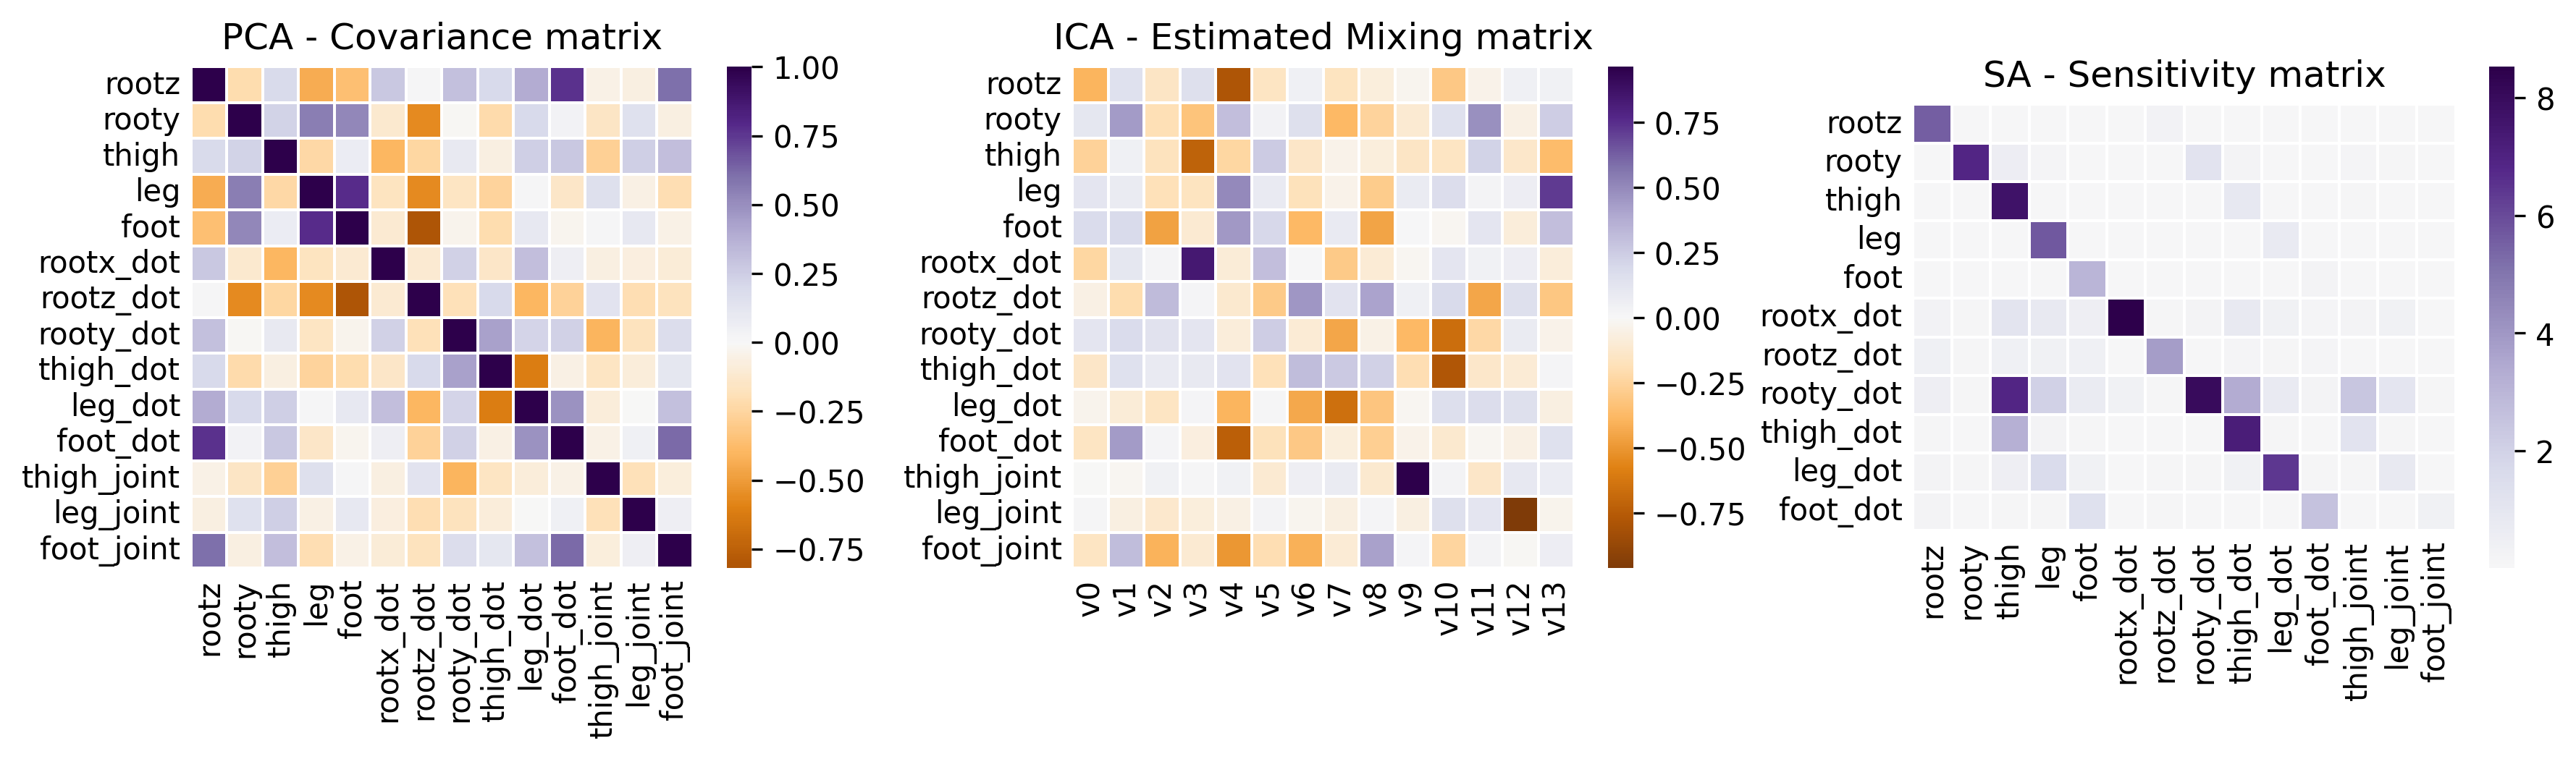

In [269]:
f, axes = plt.subplots(1, 3, figsize=(14.5, 3), gridspec_kw={'wspace':0.3}, dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=state_names[env_name]+action_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0])
axes[0].set_title('PCA - Covariance matrix')
axes[0].tick_params(axis='both', which='both', length=0)

df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[1])
axes[1].set_title('ICA - Estimated Mixing matrix')
axes[1].tick_params(axis='both', which='both', length=0)

df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
axes[2].set_title('SA - Sensitivity matrix')
axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps.pdf")
plt.show()

<Figure size 640x480 with 0 Axes>

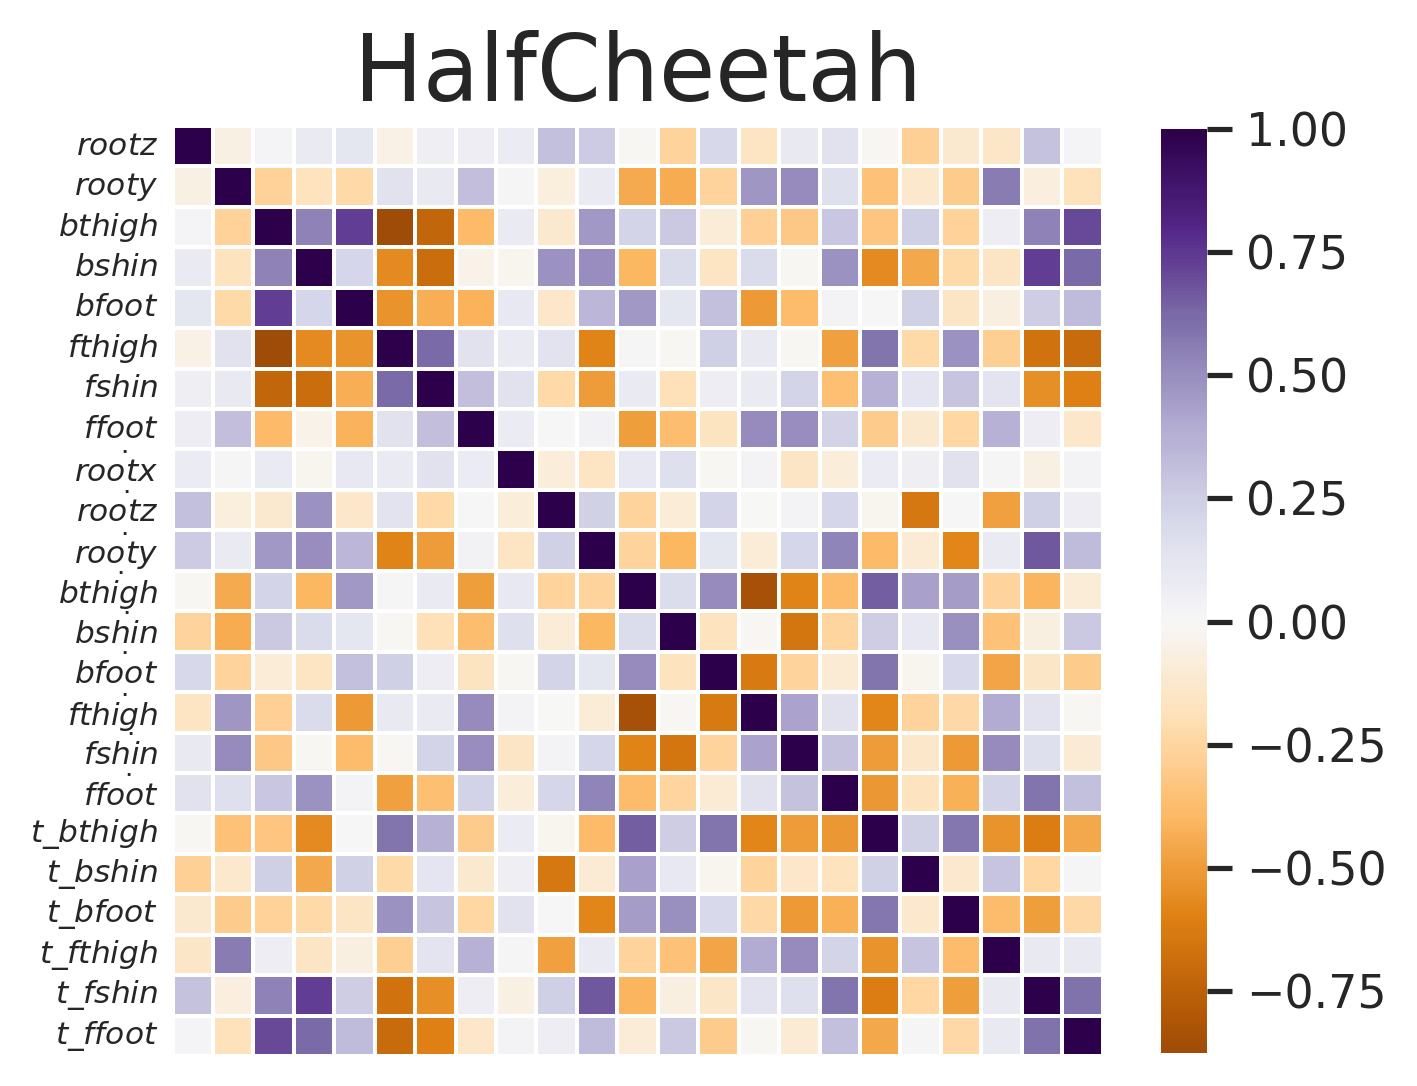

In [160]:
sns.set_theme(style="whitegrid", font_scale=1)
sns.set_palette("colorblind")
sns.despine()
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = list(np.array(axes).flatten())

# sa_scaled = (copy.copy(sa) - sa.min()) / (sa.max() - sa.min())

df = pd.DataFrame(np.cov(obs_scaled, rowvar=False), index=state_names[env_name]+action_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0], cbar_kws={"shrink": 0.8})

# df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0], cbar_kws={"shrink": 0.6})

axes[0].set_title(env_name, fontsize=22)
axes[0].tick_params(axis='both', which='both', length=0)
axes[0].set_xticklabels([])

# for item in (axes[0].get_xticklabels()):
#     item.set_fontsize(8)

for item in (axes[0].get_yticklabels()):
    item.set_fontsize(7.5)

# df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[1])
# axes[1].set_title('ICA - Estimated Mixing matrix')
# axes[1].tick_params(axis='both', which='both', length=0)

# df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
# axes[2].set_title('SA - Sensitivity matrix')
# axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_cov.pdf", bbox_inches='tight')
plt.show()

In [56]:
state_names[env_name]+action_names[env_name]

['$rootz$',
 '$rooty$',
 '$thigh$',
 '$leg$',
 '$foot$',
 '$\\dot{rootx}$',
 '$\\dot{rootz}$',
 '$\\dot{rooty}$',
 '$\\dot{thigh}$',
 '$\\dot{leg}$',
 '$\\dot{foot}$',
 '$t\\_thigh$',
 '$t\\_leg$',
 '$t\\_foot$']

<Figure size 640x480 with 0 Axes>

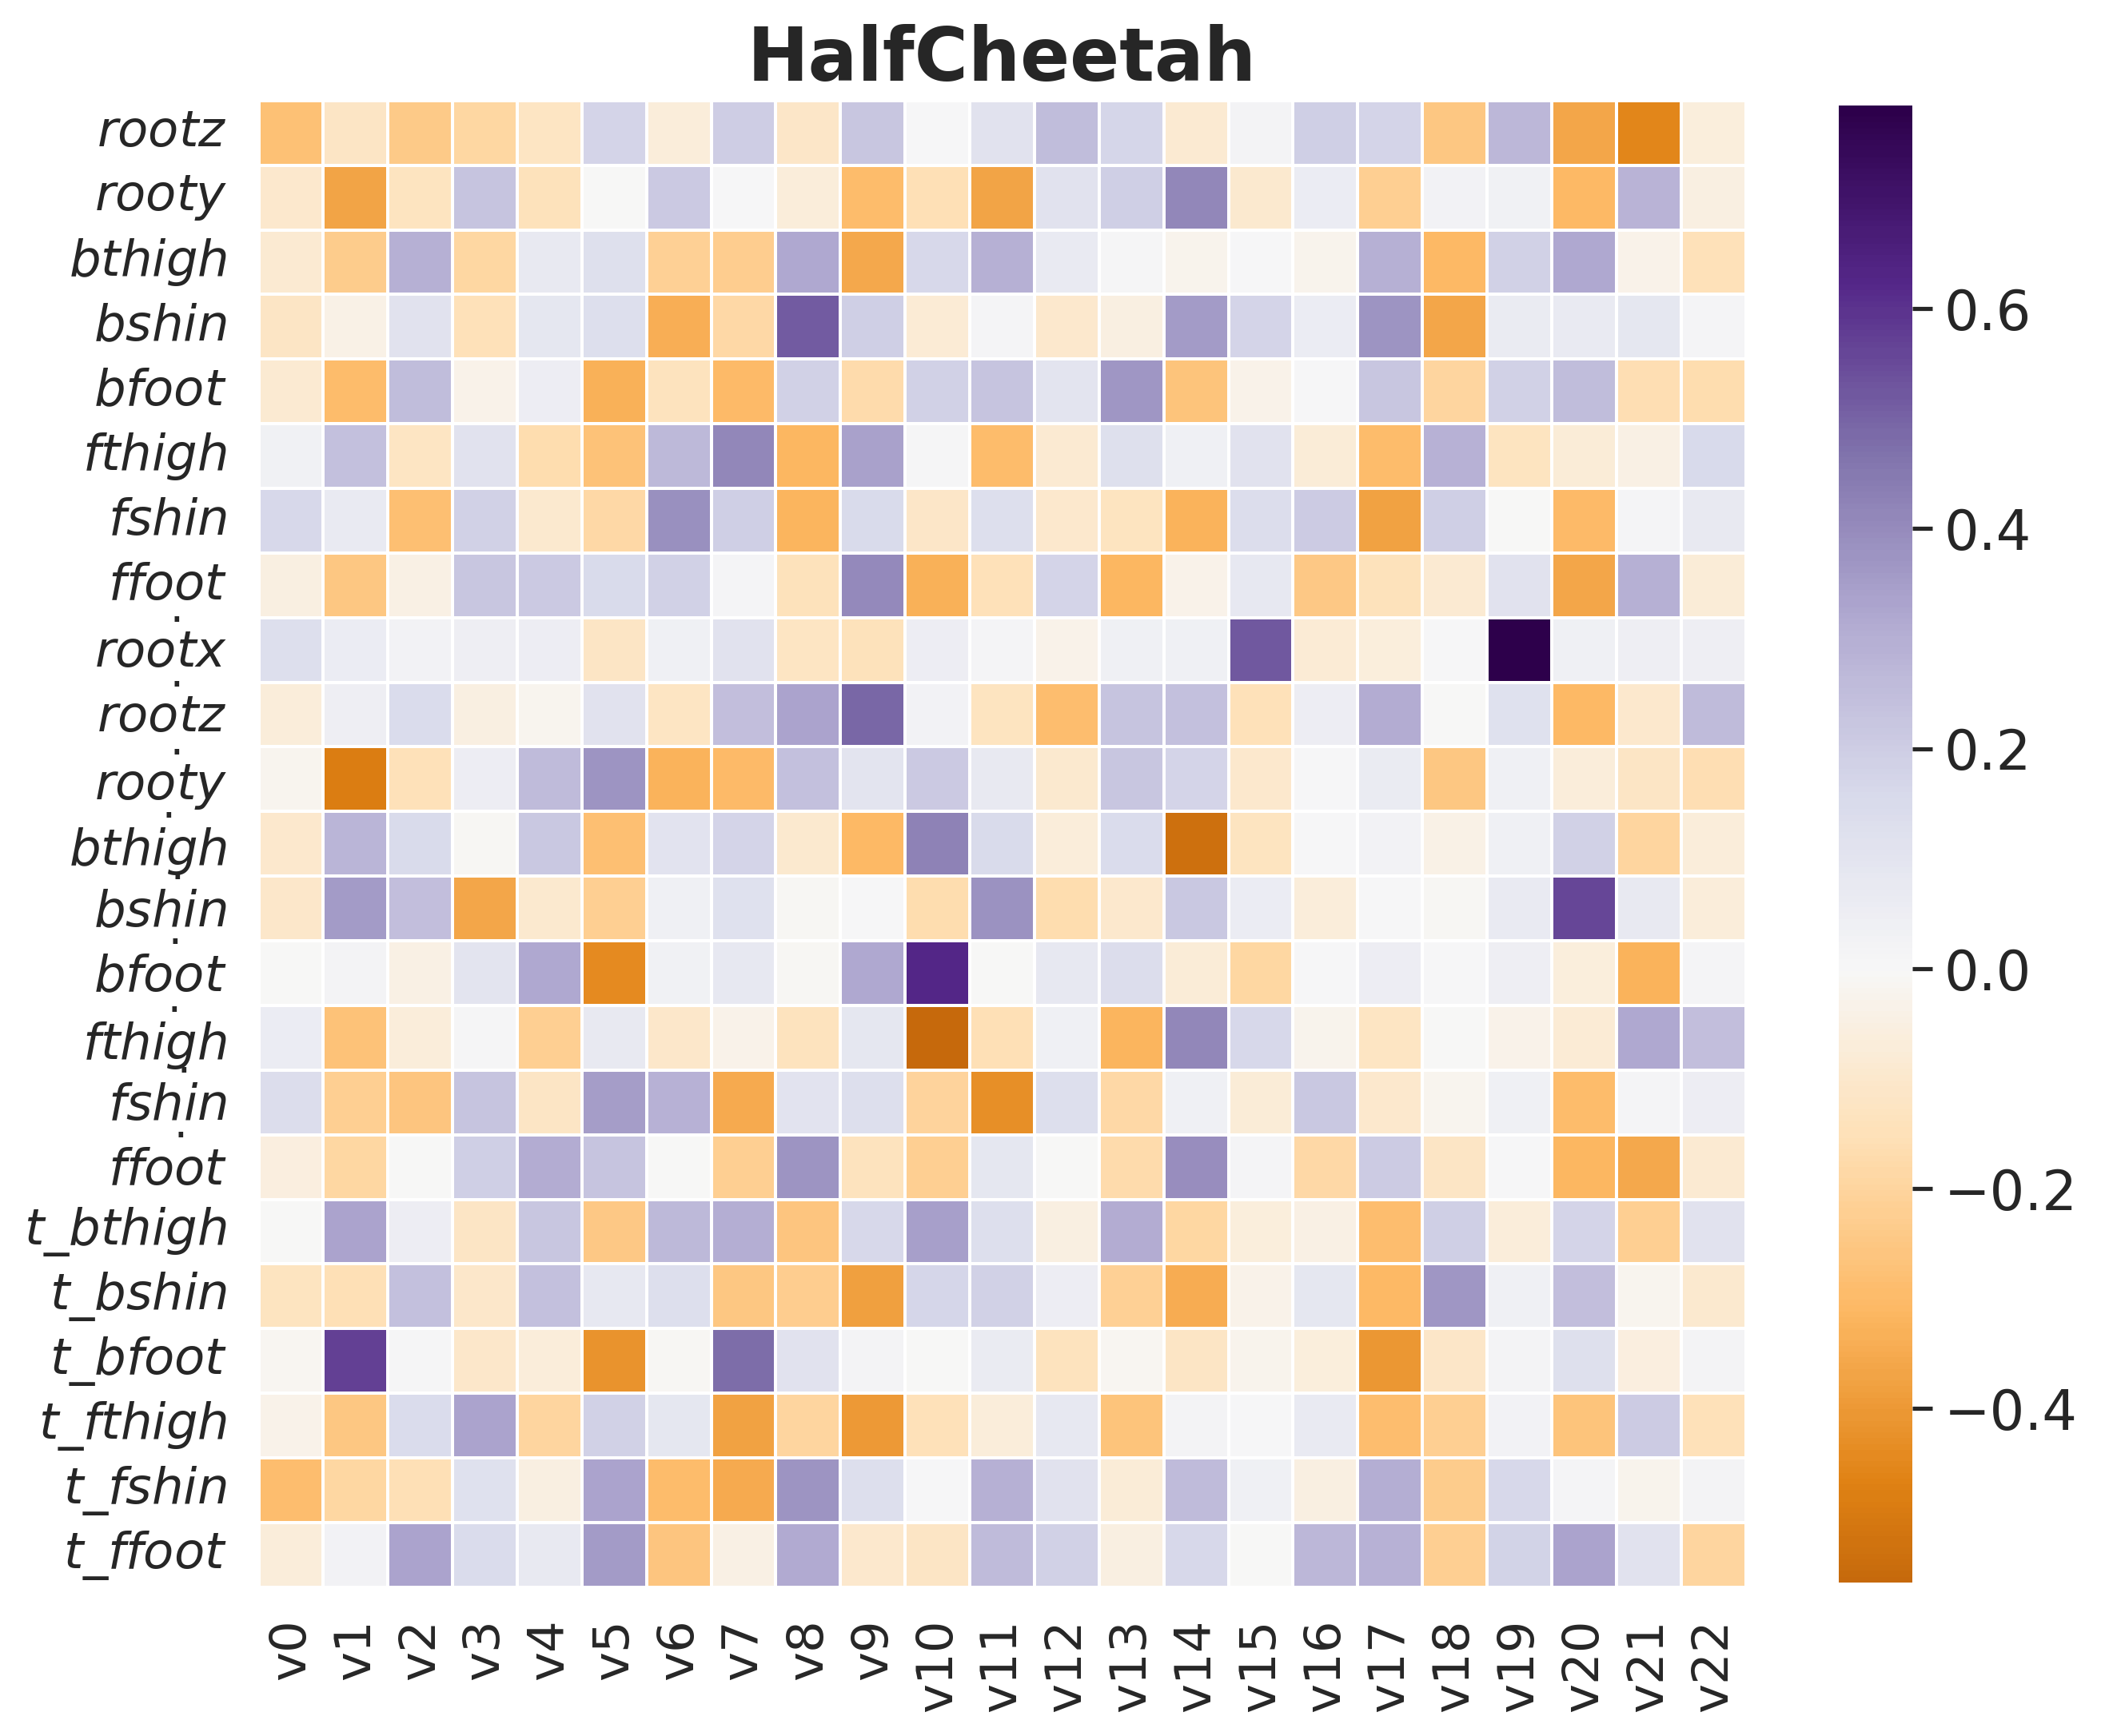

In [147]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(ica.mixing_, index=state_names[env_name]+action_names[env_name], columns=[f'v{i}' for i in range(n_components)])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(env_name, fontsize=22, weight='bold')
# axes[0].tick_params(axis='both', which='both', length=0)

for item in ([axes[0].xaxis.label, axes[0].yaxis.label] + axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    item.set_fontsize(15)

# df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
# sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[2])
# axes[2].set_title('SA - Sensitivity matrix')
# axes[2].tick_params(axis='both', which='both', length=0)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_ica.pdf")
plt.show()

<Figure size 640x480 with 0 Axes>

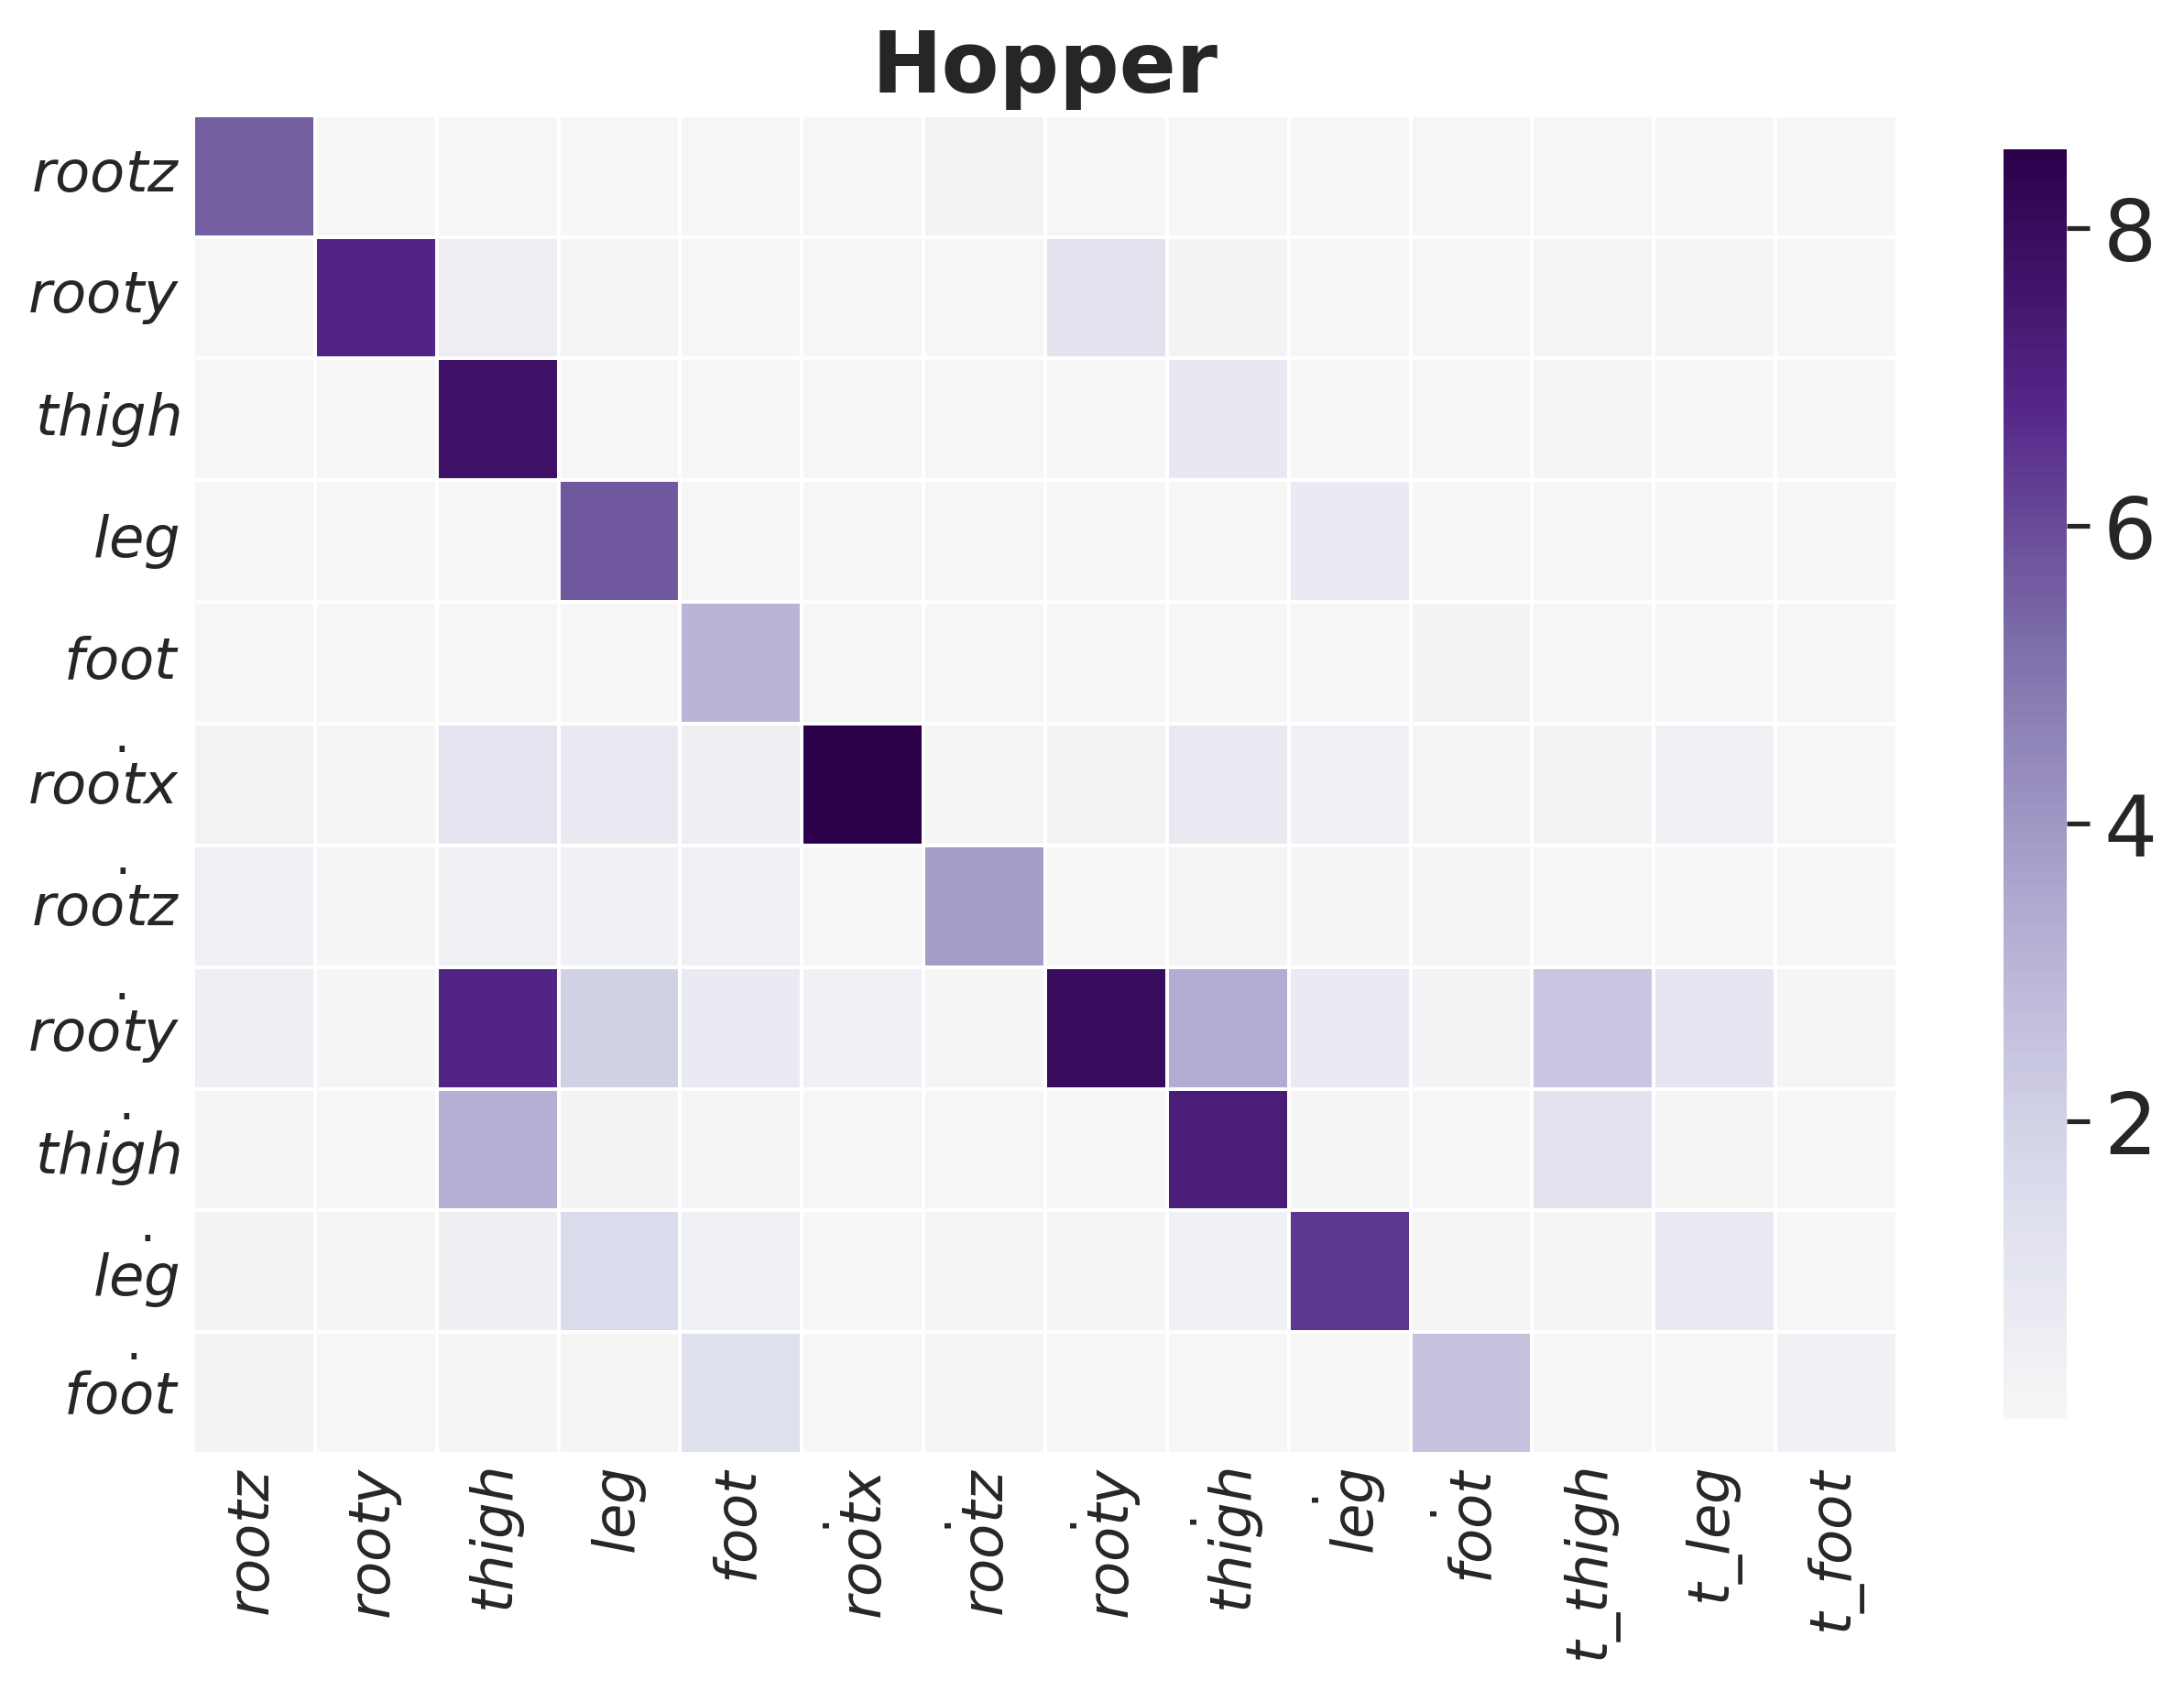

In [48]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()
# sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
axes = list(np.array(axes).flatten())

df = pd.DataFrame(sa, index=state_names[env_name], columns=state_names[env_name]+action_names[env_name])
sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0, ax=axes[0], cbar_kws={"shrink": 0.6})
axes[0].set_title(env_name, fontsize=22, weight='bold')
axes[0].tick_params(axis='both', which='both', length=0)

for item in ([axes[0].xaxis.label, axes[0].yaxis.label] + axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    item.set_fontsize(15)

# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
plt.savefig(f"/mnt/vdb/abenechehab/icl_paper/figures/heatmaps_sa.pdf")
plt.show()

# ICL

In [47]:
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,  # n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(
    verbose=1,
    llama_3_tokenizer=True,
    stochastic=False
)
icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


## Inverse transform

In [48]:
def invert_pca(icl_object, reduction_object, use_scaler=True):
    groundtruth = scaling_pipeline.transform(X[init_index+1:init_index+context_length+1, :n_components])
    scaled_mean_error = []
    if use_scaler:
        predictions = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1)))[:, :n_observations]
    else:
        predictions = reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1))[:, :n_observations]
    all_mean = []
    all_mode = []
    all_lb = []
    all_ub = []
    for dim in range(n_components):
        ts_max = icl_object[dim].rescaling_max
        ts_min = icl_object[dim].rescaling_min
        # # -------------------- Useful for Plots --------------------
        mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
        mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

        all_mean.append(mean_arr[..., None])
        all_mode.append(mode_arr[..., None])
        all_lb.append(mean_arr[..., None] - sigma_arr[..., None])
        all_ub.append(mean_arr[..., None] + sigma_arr[..., None])

    if use_scaler:
        scaled_mean_error = np.abs(np.concatenate(all_mean, axis=1)[-100:] - groundtruth[-100:, :]).mean(axis=0)
    else:
        scaled_mean_error = np.abs(scaling_pipeline.transform(np.concatenate(all_mean, axis=1)[-100:]) - groundtruth[-100:, :]).mean(axis=0)
    
    if use_scaler:
        all_mean = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mean, axis=1)))[:, :n_observations]
        all_mode = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mode, axis=1)))[:, :n_observations]
        all_lb = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_lb, axis=1)))[:, :n_observations]
        all_ub = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_ub, axis=1)))[:, :n_observations]
    else:
        all_mean = reduction_object.inverse_transform(np.concatenate(all_mean, axis=1))[:, :n_observations]
        all_mode = reduction_object.inverse_transform(np.concatenate(all_mode, axis=1))[:, :n_observations]
        all_lb = reduction_object.inverse_transform(np.concatenate(all_lb, axis=1))[:, :n_observations]
        all_ub = reduction_object.inverse_transform(np.concatenate(all_ub, axis=1))[:, :n_observations]

    print(scaled_mean_error)

    return predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error

## visu

In [49]:
data = {
    'Category': state_names[env_name],
}

[0.17497109 0.07804663 0.33093417 0.43003749 0.35928585 0.38470092
 0.53513544 0.39479515 0.31593001 0.65865393 0.67869696 0.44441494
 0.53038402 0.57107872 0.54617086 0.5976463  0.5089053  0.26571186]


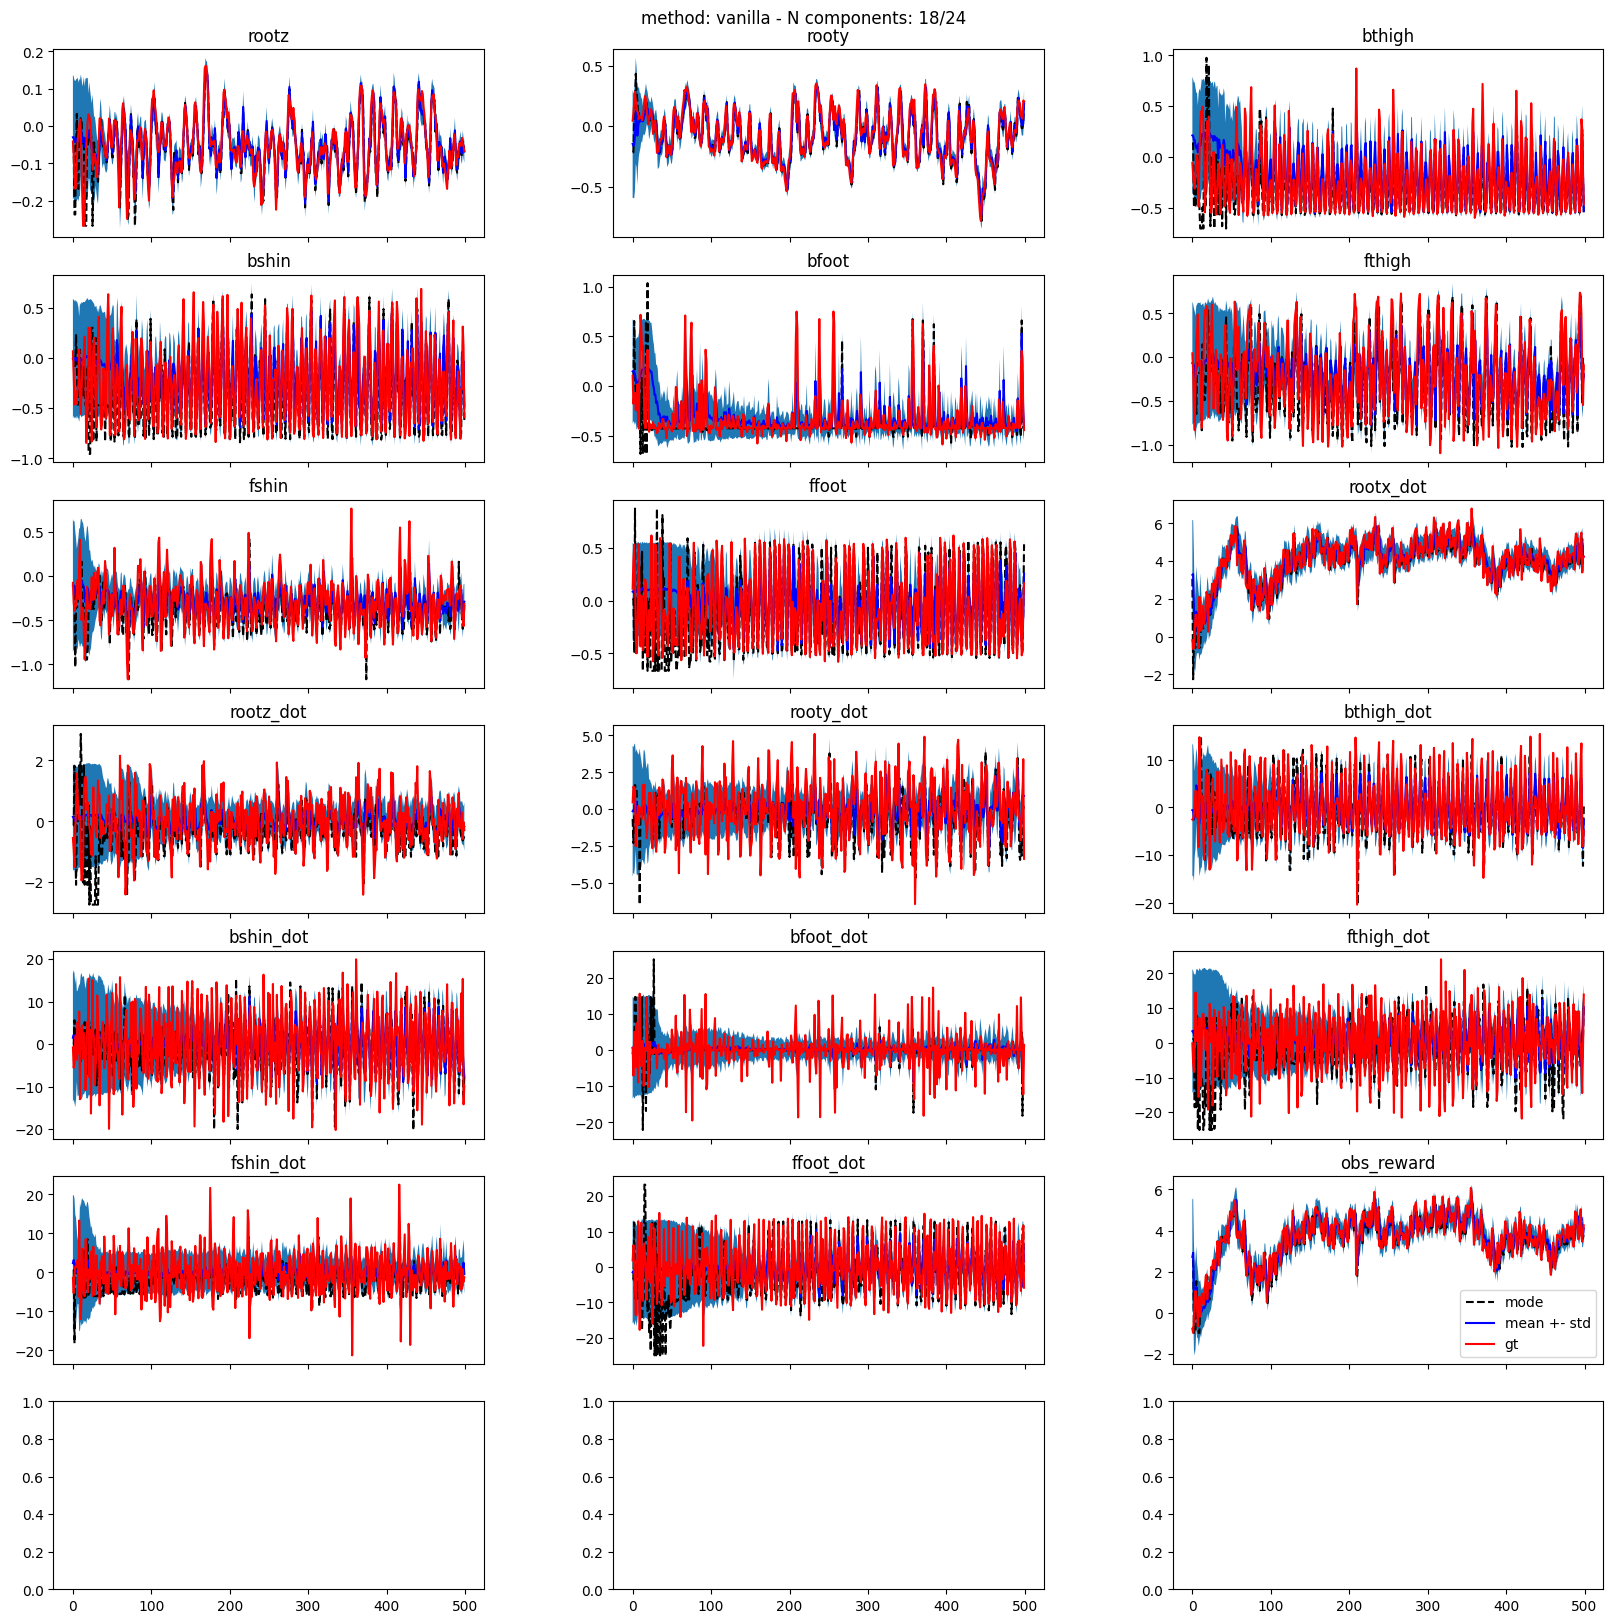

In [50]:
method = 'vanilla'
label = r'vanilla' # r'$(s)$-ICA'

if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=False)

# data for radar chart
data[label] = scaled_mean_error[:n_observations]

start_from=0
f, axes = plt.subplots(n_observations//3+1, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1, dim].flatten()

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])

    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--',label='mode')
    axes[dim].plot(x[start_from:], all_mean[start_from:, dim], label='mean +- std', color='blue')
    axes[dim].fill_between(x=x[start_from:], y1=all_lb[start_from:, dim], y2=all_ub[start_from:, dim])
    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red')
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    # if dim > 15:
    #     axes[dim].set_xlabel("timesteps")
axes[dim].legend()
f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## radar chart

In [276]:
df = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/radar_chart_{env_name}_{data_label}_ep{episode}.csv', index_col=0)
df['vanilla'] = scaled_mean_error[:n_observations]
df

Category  $(s,a)$-PCA  $(s,a)$-ICA  $(s)$-PCA  $(s)$-ICA   vanilla  \
0        rootz     1.851423     0.644120   1.692034   0.651048  0.174971   
1        rooty     1.474121     0.326645   1.326850   0.342697  0.078047   
2       bthigh     0.919244     0.768541   0.975000   0.919077  0.330934   
3        bshin     0.965901     1.010699   0.970081   1.576298  0.430037   
4        bfoot     0.621562     0.599489   0.593023   0.590355  0.359286   
5       fthigh     0.708455     0.728187   0.736431   0.718518  0.384701   
6        fshin     0.764482     0.689970   0.636691   0.800771  0.535135   
7        ffoot     0.900532     0.934839   0.948422   0.970537  0.394795   
8    rootx_dot     0.345766     0.384846   0.334478   0.449786  0.315930   
9    rootz_dot     0.684837     0.690144   0.706650   0.734226  0.658654   
10   rooty_dot     0.837811     0.897949   0.821717   0.859257  0.678697   
11  bthigh_dot     0.800563     0.919289   0.795131   0.590308  0.444415   
12   bshin_dot     0.944856     1.202995   0.919880   1.006408  0.530384   
13   bfoot_dot     0.591974     0.588342   0.674744   0.890081  0.571079   
14  fthigh_dot     0.681454     0.704712   0.668076   0.692765  0.546171   
15   fshin_dot     0.697480     0.783875   0.699081   0.707135  0.597646   
16   ffoot_dot     0.948953     0.955140   0.903812   0.834004  0.508905   

    vanilla rescaled  
0           0.174971  
1           0.078047  
2           0.330934  
3           0.430037  
4           0.359286  
5           0.384701  
6           0.535135  
7           0.394795  
8           0.315930  
9           0.658654  
10          0.678697  
11          0.444415  
12          0.530384  
13          0.571079  
14          0.546171  
15          0.597646  
16          0.508905

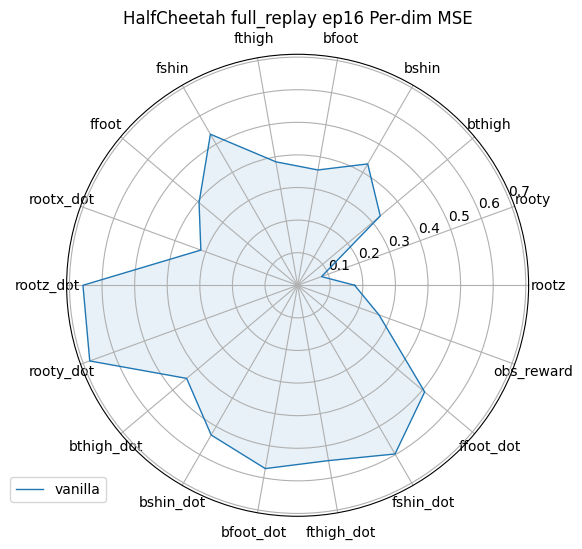

In [51]:
df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
for label in df.keys():
    if label != 'Category':
        values = df[label].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title(f'{env_name} {data_label} ep{episode} Per-dim MSE')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [243]:
df.to_csv(f'/mnt/vdb/abenechehab/icl_paper/radar_chart_{env_name}_{data_label}_ep{episode}.csv')

## multi-step

In [52]:
prediction_horizon = 50

# recreate the trainer
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True, verbose=1)

prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [40:01<00:00, 48.03s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


[0.60011863 0.36462884 1.36943994 1.51365093 0.70710713 1.05385798
 0.8734813  1.35605646 0.49193373 0.68991435 0.93942294 1.37746139
 1.23317183 0.75240626 0.80684793 0.8135389  1.3858076  0.43659271]


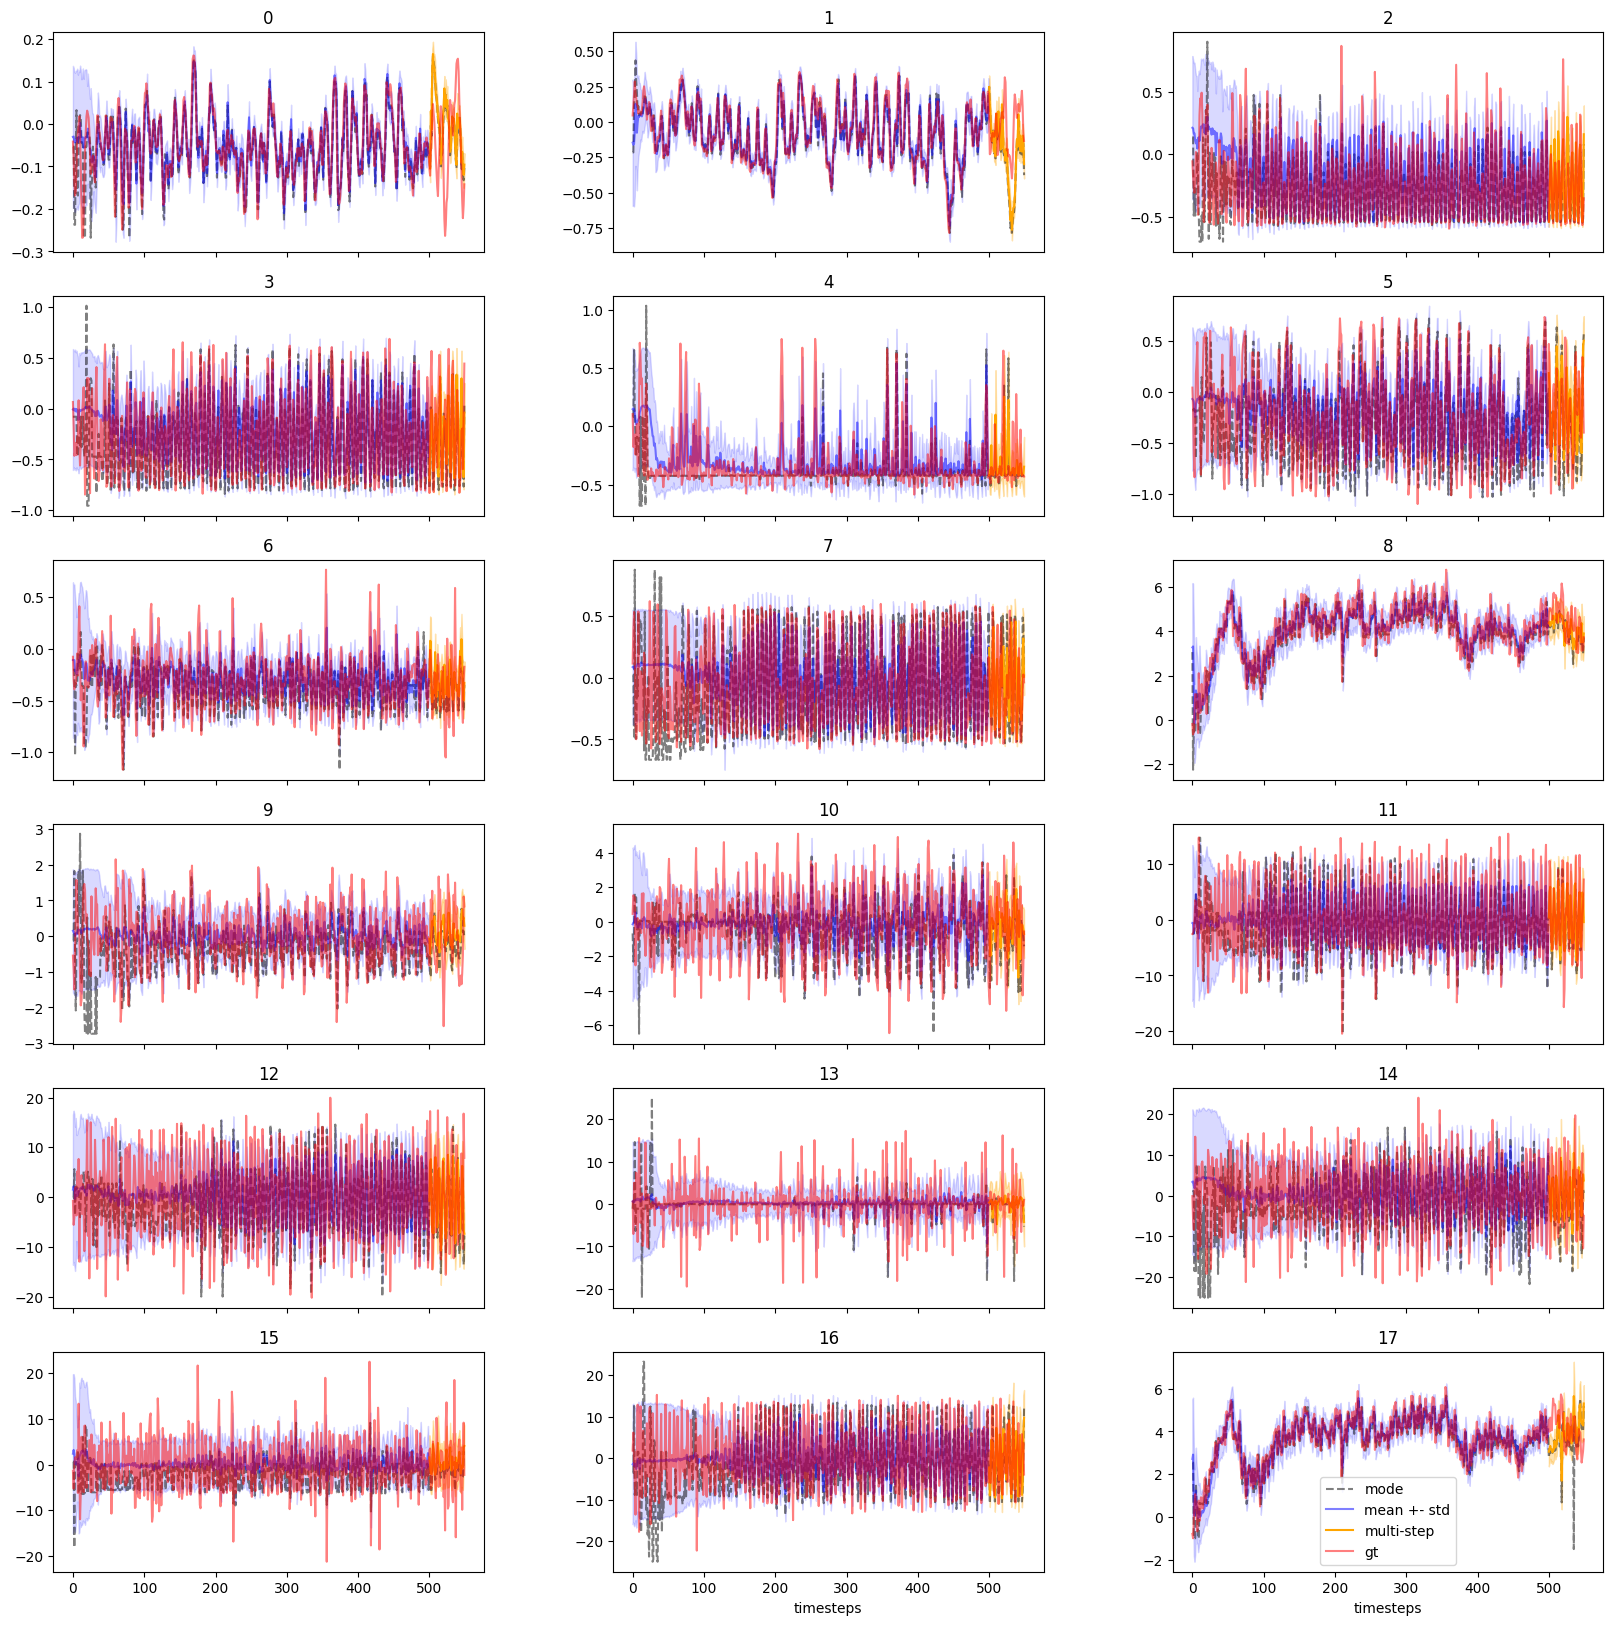

In [54]:
method = 'vanilla'
label = r'$(s)$-PCA'

if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=False)

start_from = 0
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])
    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], all_mean[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=all_lb[start_from:-prediction_horizon, dim], 
        y2=all_ub[start_from:-prediction_horizon, dim],
        alpha=.15,
        color='blue',
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], all_mean[-prediction_horizon:, dim], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=all_lb[-prediction_horizon:, dim], 
        y2=all_ub[-prediction_horizon:, dim],
        alpha=.3,
        color='orange',
    )

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/pca-{env_name}_{data_label}_ep{episode}.png")
plt.show()

## multi-step MC

In [55]:
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=9.99,
    up_shift=0.0,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length
)

trainer.icl(verbose=1)

icl_object = trainer.compute_statistics()

# MC kernel
transition_matrix_NN, transition_matrix_OT = trainer.build_tranistion_matrices(verbose=0)

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:45<00:00,  2.51s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
icl / state dim:   0%|                                                                                            | 0/18 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/matrix_completion/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(

KeyboardInterrupt: 

In [290]:
prediction_horizon = 500

# multi-step prediction
mode_mc_predictions = trainer.predict_long_horizon_MC(
    prediction_horizon=prediction_horizon,
    sampling='mode'
)
mean_mc_predictions = trainer.predict_long_horizon_MC(
    prediction_horizon=prediction_horizon,
    sampling='mean'
)

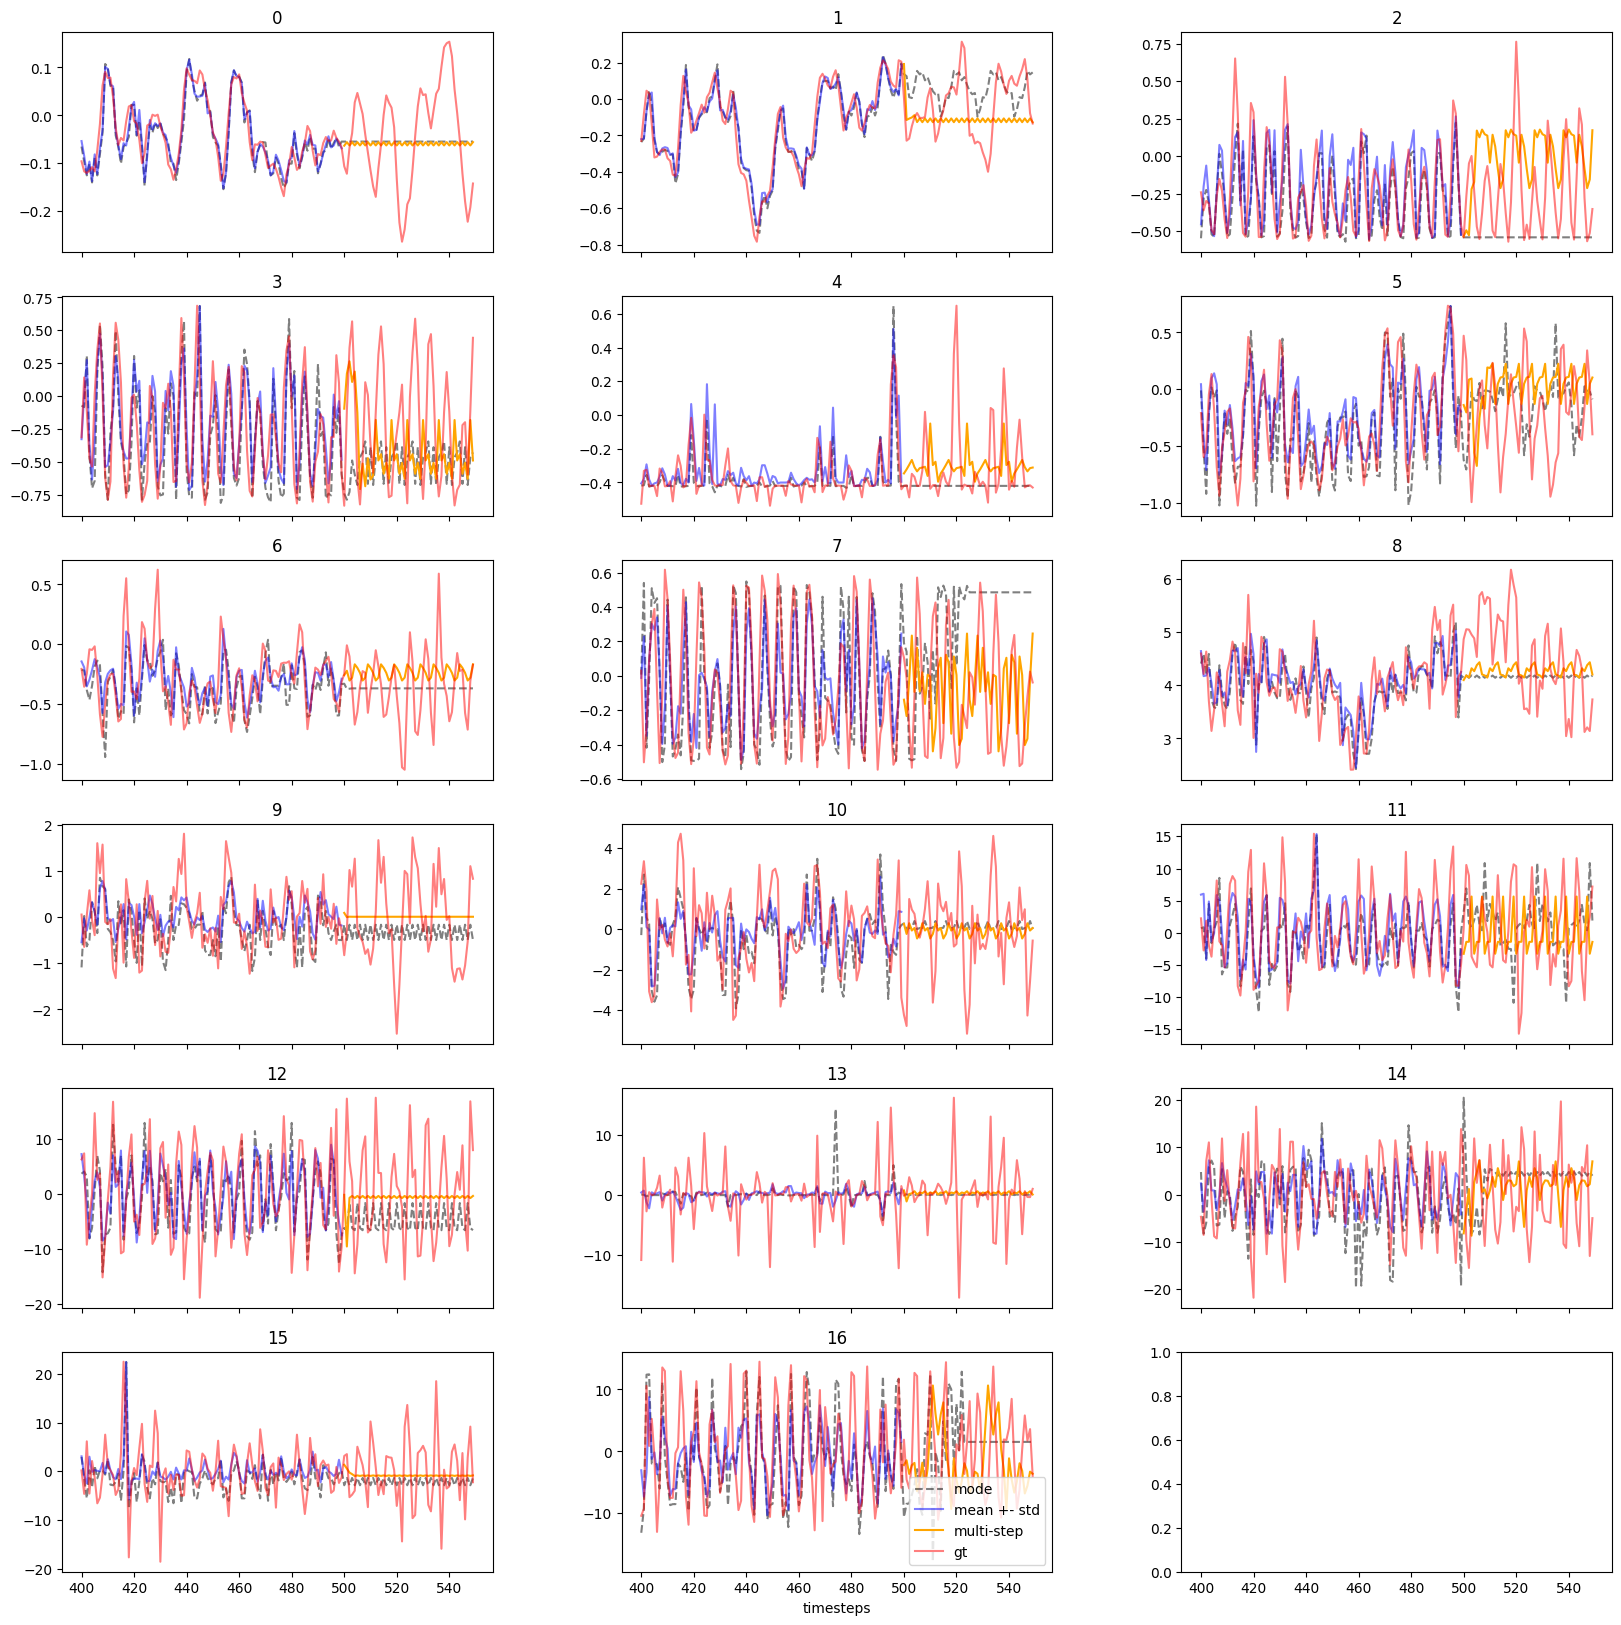

In [291]:
# rescale data
mode_arr = mode_mc_predictions  # scaling_pipeline.inverse_transform(mode_mc_predictions)
mc_predictions = mean_mc_predictions  # scaling_pipeline.inverse_transform(mean_mc_predictions)

start_from = 400
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mc_predictions.shape[0])
    axes[dim].plot(x[start_from:], mode_arr[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mc_predictions[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)

    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mc_predictions[-prediction_horizon:, dim], label='multi-step', color='orange')

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

# Toy MDP

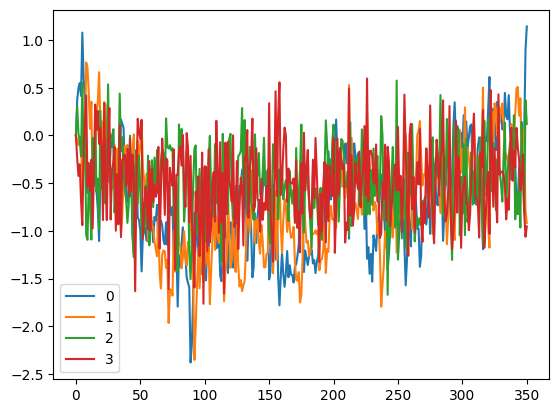

In [349]:
# Define the MDP parameters
A = np.array([[0.8, 0.2, 0.5, -0.5],
              [0.3, 0.7, -0.5, 0.5],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
sigma = 0.1
c = np.array([1.0, -1.0, 0.0, 0.0])
omega = 0.1

# Define a policy that selects continuous actions based on the current state
def policy(state):
    return np.random.normal(loc=0.1 * state[0] - 0.4, scale=0.4, size=2)  # Random continuous actions

# Define a policy that selects continuous actions based on the current state
def policy2(state):
    # Simple linear policy: action = K * state
    K = np.array([[0.5, -0.5],
                  [-0.5, 0.5]])
    return np.dot(K, state)

# Simulate a trajectory
np.random.seed(0)
n_steps = context_length+prediction_horizon+1
states = np.zeros((n_steps, 2))
actions = np.zeros((n_steps, 2))

for t in range(1, n_steps):
    action = policy(states[t-1])
    actions[t] = action
    noise = np.random.normal(0, sigma, 4)
    # sinusoidal = c * np.sin(omega * t)
    combined_state_action = np.hstack((states[t-1], action))
    next_combined_state_action = np.dot(A, combined_state_action) + noise # + sinusoidal
    states[t] = next_combined_state_action[:2]

# Concatenate states and actions
combined_data = np.hstack((states, actions))

for i in range(4):
    plt.plot(combined_data[:,i], label=i)
plt.legend()
plt.show()

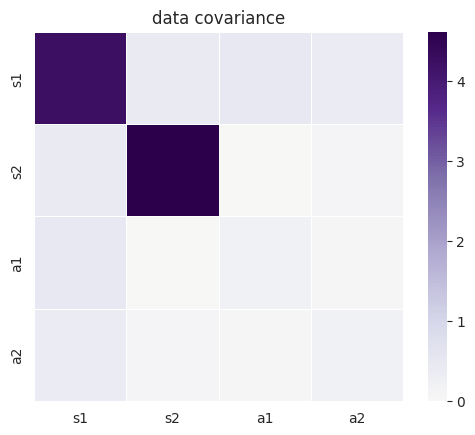

In [339]:
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

n_components = 4

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(combined_data[:context_length, :n_components])
obs_scaled = scaling_pipeline.transform(combined_data[:context_length, :n_components])

columns = ['s1', 's2', 'a1', 'a2']

with sns.axes_style("white"):
    plt.figure()
    df = pd.DataFrame(np.cov(combined_data, rowvar=False), index=columns, columns=columns)
    ax = sns.heatmap(df, linewidth=0.5, square=True, cmap="PuOr", center=0.0)
    ax.set_title('data covariance')

In [343]:
method = 'ica'

if method == 'id':
    identity = IdentityTransformer()
    # time_series = identity.transform(scaling_pipeline.transform(X[init_index:init_index+context_length, :n_original_components]))
    time_series = identity.transform(obs_scaled[:-1, :])
elif method == 'pca':
    # pca
    n_components = 4 
    pca = PCA(n_components=n_components)
    pca.fit(obs_scaled)
    time_series = pca.transform(obs_scaled[:-1, :])
elif method == 'ica':
    # ica
    n_components = 4 
    ica = FastICA(n_components=n_components)
    ica.fit(obs_scaled)
    time_series = ica.transform(obs_scaled[:-1, :])

In [344]:
prediction_horizon = 50

# recreate the trainer
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True, verbose=1)

prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [06:12<00:00,  7.45s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


[0.75720827 0.65341573 0.9880632  0.64044108]


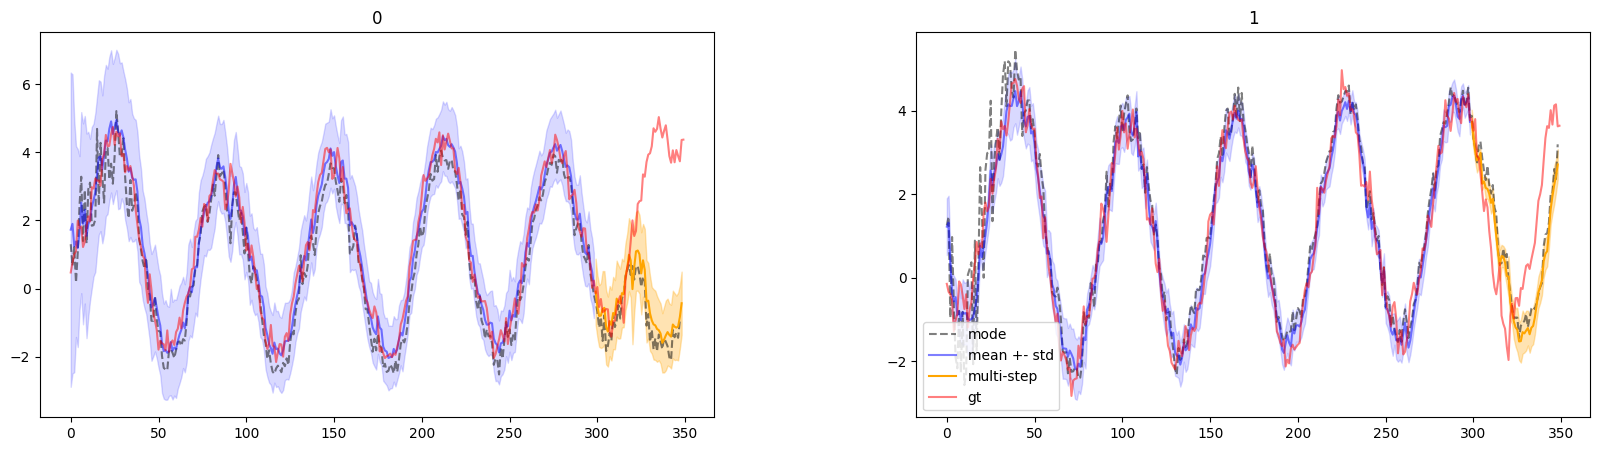

In [346]:
if method == 'pca':
    reduction_object = pca  
elif method == 'ica':
    reduction_object = ica  
else:
    reduction_object = identity  
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=reduction_object, use_scaler=True)

start_from=0
f, axes = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(2):
    groundtruth = combined_data[1:context_length+prediction_horizon+1, dim].flatten()
    size_all = len(groundtruth)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(predictions.shape[0])
    axes[dim].plot(x[start_from:], all_mode[start_from:, dim], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], all_mean[start_from:-prediction_horizon, dim], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=all_lb[start_from:-prediction_horizon, dim], 
        y2=all_ub[start_from:-prediction_horizon, dim],
        alpha=.15,
        color='blue',
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], all_mean[-prediction_horizon:, dim], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=all_lb[-prediction_horizon:, dim], 
        y2=all_ub[-prediction_horizon:, dim],
        alpha=.3,
        color='orange',
    )

    axes[dim].plot(np.arange(groundtruth.shape[0])[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
axes[dim].legend()
# f.suptitle(f'method: {method} - N components: {n_components}/{n_observations+n_actions}', y=0.9)
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

In [174]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ]
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ]
}

new_notation_state = {
'HalfCheetah': [
    r"$rootz$",
    r"$rooty$",
    r"$bthigh$",
    r"$bshin$",
    r"$bfoot$",
    r"$fthigh$",
    r"$fshin$",
    r"$ffoot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{bthigh}$",
    r"$\dot{bshin}$",
    r"$\dot{bfoot}$",
    r"$\dot{fthigh}$",
    r"$\dot{fshin}$",
    r"$\dot{ffoot}$",
],
'Hopper': [
    r"$rootz$",
    r"$rooty$",
    r"$thigh$",
    r"$leg$",
    r"$foot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{thigh}$",
    r"$\dot{leg}$",
    r"$\dot{foot}$",
],
} 

In [277]:
env_name = 'HalfCheetah'
data_label = 'expert'
nep = 5
prediction_horizon = 20

df_baselines = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/baselines_radar_chart_{env_name}_{data_label}_Nep{nep}_predhorizon{prediction_horizon}.csv', index_col=0)
df_baselines

Category    linear  linear+actions       mlp  mlp+actions  llm mean  \
0        rootz  1.120861        1.314519  1.354859     0.681771  0.373365   
1        rooty  1.209822        1.687651  2.335154     2.188134  3.756585   
2       bthigh  3.110009        3.387061  4.060313     3.242838  0.013668   
3        bshin  1.177762        1.645151  0.548579     1.530885  0.135637   
4        bfoot  2.423724        2.136458  3.292299     2.339686  1.898043   
5       fthigh  2.681169        3.278382  3.560516     2.993906  0.040343   
6        fshin  1.217996        2.749214  0.983623     3.015879  0.554879   
7        ffoot  2.294689        2.677264  2.030616     2.955388  1.348025   
8    rootx_dot  0.357616        0.250235  0.721599     0.635357  0.206331   
9    rootz_dot  1.274339        0.595843  3.257173     0.893610  2.990384   
10   rooty_dot  0.626069        2.312489  0.757213     2.687604  0.091523   
11  bthigh_dot  2.890944        4.116703  2.790413     4.247520  0.019660   
12   bshin_dot  2.569002        1.531419  4.243151     1.275181  0.324656   
13   bfoot_dot  3.617347        4.518074  5.773397     4.416788  1.178942   
14  fthigh_dot  1.663768        2.577383  1.731055     2.613976  0.009204   
15   fshin_dot  2.202211        2.678112  2.557122     2.691825  0.375613   
16   ffoot_dot  1.602648        1.918099  1.557382     2.046400  0.710753   

    llm mode  
0   0.307870  
1   4.653653  
2   0.015646  
3   0.147854  
4   1.935530  
5   0.041750  
6   0.703007  
7   1.712839  
8   0.199093  
9   3.093327  
10  0.116788  
11  0.018477  
12  0.268886  
13  1.157401  
14  0.017244  
15  0.395121  
16  0.822769

In [278]:
exp_name = 'inverted'
n_episodes = 3
pca_df = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/full_pipeline_{exp_name}_{env_name}_{data_label}_nep{n_episodes}_predh{prediction_horizon}_halfcomp.csv', index_col=0)
mode_or_mean = 'mean'
h0 = 400
h1 = 420
pca_df_copy = copy.copy(
    pca_df.loc[
        (pca_df['mode_or_mean']==mode_or_mean) & (pca_df['prediction_horizon']>=h0) & (pca_df['prediction_horizon']<=h1), ['label']+state_names[env_name]
    ].groupby(['label']).mean().T.reset_index()
)
pca_df_copy = pca_df_copy.rename(columns={"index": "Category"})
pca_df_copy

label    Category  ICL-$(s)$-PCA  ICL-$(s,a)$-PCA      vICL
0           rootz       0.587267         0.552431  0.668973
1           rooty       0.621304         0.613148  1.195579
2          bthigh       0.318785         0.260011  0.087451
3           bshin       0.586561         0.424096  0.934311
4           bfoot       0.496326         0.452222  1.049462
5          fthigh       0.533901         0.384653  0.731189
6           fshin       0.509721         0.462944  0.812750
7           ffoot       0.652549         0.568519  1.012764
8       rootx_dot       0.308798         0.480648  0.222570
9       rootz_dot       0.844481         0.741558  0.853822
10      rooty_dot       0.552353         0.457315  0.861941
11     bthigh_dot       0.458857         0.309418  0.424063
12      bshin_dot       0.594779         0.328498  0.624403
13      bfoot_dot       0.687835         0.563742  0.848626
14     fthigh_dot       0.416264         0.266375  0.926168
15      fshin_dot       0.534674         0.427507  0.970478
16      ffoot_dot       0.669469         0.519148  0.831697

In [279]:
merge_dfs = pd.concat([df_baselines, pca_df_copy.iloc[:,1:]], axis=1)
merge_dfs

Category    linear  linear+actions       mlp  mlp+actions  llm mean  \
0        rootz  1.120861        1.314519  1.354859     0.681771  0.373365   
1        rooty  1.209822        1.687651  2.335154     2.188134  3.756585   
2       bthigh  3.110009        3.387061  4.060313     3.242838  0.013668   
3        bshin  1.177762        1.645151  0.548579     1.530885  0.135637   
4        bfoot  2.423724        2.136458  3.292299     2.339686  1.898043   
5       fthigh  2.681169        3.278382  3.560516     2.993906  0.040343   
6        fshin  1.217996        2.749214  0.983623     3.015879  0.554879   
7        ffoot  2.294689        2.677264  2.030616     2.955388  1.348025   
8    rootx_dot  0.357616        0.250235  0.721599     0.635357  0.206331   
9    rootz_dot  1.274339        0.595843  3.257173     0.893610  2.990384   
10   rooty_dot  0.626069        2.312489  0.757213     2.687604  0.091523   
11  bthigh_dot  2.890944        4.116703  2.790413     4.247520  0.019660   
12   bshin_dot  2.569002        1.531419  4.243151     1.275181  0.324656   
13   bfoot_dot  3.617347        4.518074  5.773397     4.416788  1.178942   
14  fthigh_dot  1.663768        2.577383  1.731055     2.613976  0.009204   
15   fshin_dot  2.202211        2.678112  2.557122     2.691825  0.375613   
16   ffoot_dot  1.602648        1.918099  1.557382     2.046400  0.710753   

    llm mode  ICL-$(s)$-PCA  ICL-$(s,a)$-PCA      vICL  
0   0.307870       0.587267         0.552431  0.668973  
1   4.653653       0.621304         0.613148  1.195579  
2   0.015646       0.318785         0.260011  0.087451  
3   0.147854       0.586561         0.424096  0.934311  
4   1.935530       0.496326         0.452222  1.049462  
5   0.041750       0.533901         0.384653  0.731189  
6   0.703007       0.509721         0.462944  0.812750  
7   1.712839       0.652549         0.568519  1.012764  
8   0.199093       0.308798         0.480648  0.222570  
9   3.093327       0.844481         0.741558  0.853822  
10  0.116788       0.552353         0.457315  0.861941  
11  0.018477       0.458857         0.309418  0.424063  
12  0.268886       0.594779         0.328498  0.624403  
13  1.157401       0.687835         0.563742  0.848626  
14  0.017244       0.416264         0.266375  0.926168  
15  0.395121       0.534674         0.427507  0.970478  
16  0.822769       0.669469         0.519148  0.831697

In [280]:
df = copy.copy(merge_dfs).iloc[:,[0,4,7,8,9]]

In [281]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [282]:
new_notation_state = {
'HalfCheetah': [
    r"$rootz$",
    r"$rooty$",
    r"$bthigh$",
    r"$bshin$",
    r"$bfoot$",
    r"$fthigh$",
    r"$fshin$",
    r"$ffoot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{bthigh}$",
    r"$\dot{bshin}$",
    r"$\dot{bfoot}$",
    r"$\dot{fthigh}$",
    r"$\dot{fshin}$",
    r"$\dot{ffoot}$",
],
'Hopper': [
    r"$rootz$",
    r"$rooty$",
    r"$thigh$",
    r"$leg$",
    r"$foot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{thigh}$",
    r"$\dot{leg}$",
    r"$\dot{foot}$",
],
"Walker2d": [
    "rootz",
    "rooty",
    "thigh_right_angle",
    "leg_right_angle",
    "foot_right_angle",
    "thigh_left_angle",
    "leg_left_angle",
    "foot_left_angle",
    "rootx_dot",
    "rootz_dot",
    "rooty_dot",
    "thigh_right_angle_dot",
    "leg_right_angle_dot",
    "foot_right_angle_dot",
    "thigh_left_angle_dot",
    "leg_left_angle_dot",
    "foot_left_angle_dot",
],
"Swimmer": [
    r"$free\_body_rot$",
    r"$motor1\_rot$",
    r"$motor2\_rot$",
    r"$slider1$",
    r"$slider2$",
    r"$\dot{free\_body\_rot}$",
    r"$\dot{motor1\_rot}$",
    r"$\dot{motor2\_rot}$",
]
} 

df['Category'] = new_notation_state[env_name]

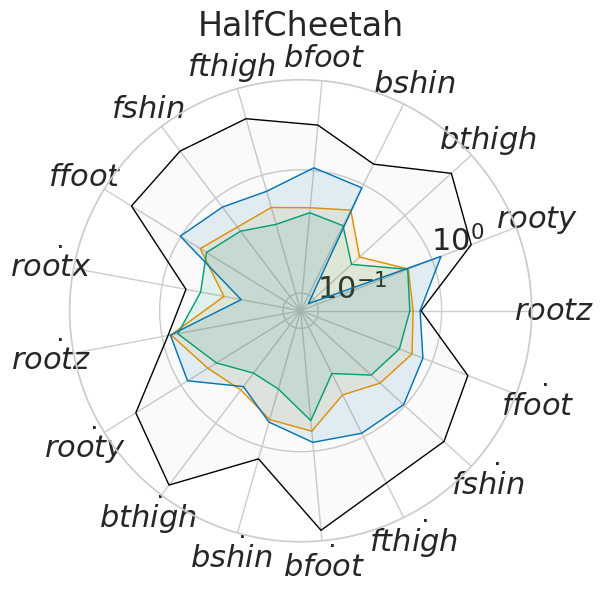

In [291]:
import matplotlib as mpl

# cmap = mpl.colormaps['tab10']
# colors = cmap(np.linspace(0, 1, 3))
cmap = mpl.colors.ListedColormap(plt.cm.tab10.colors[:3])

sty = {
    'mlp+actions': ['black', '-'],
    r'vICL': [sns.color_palette("colorblind")[0], '-'],
    r'ICL-$(s)$-PCA': [sns.color_palette("colorblind")[1], '-'],
    r'ICL-$(s,a)$-PCA': [sns.color_palette("colorblind")[2], '-'],
}

# plt.style.use('seaborn-v0_8-classic')
# plt.style.use(['seaborn-v0_8-talk'])

# df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_rscale('log', base=10)


# First dataset
for label in df.keys():
    if label != 'Category':
        values = df[label].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, label=label, color=sty[label][0], linestyle=sty[label][1])
        if label=='mlp+actions':
            ax.fill(angles, values, alpha=0.02, color=sty[label][0])
        else:
            ax.fill(angles, values, alpha=0.1, color=sty[label][0])
# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title(f'{env_name}')

# Add a legend
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.1), ncol=6)
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/comp_baselines_{env_name}_no_leg_logarithmic.pdf', bbox_inches='tight')
plt.show()

In [75]:
df_all = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe.csv', index_col=0).reset_index()
df_all['value_error'] = np.abs(df_all['value_error'])
df_all

index       mean     sigma       mode       pred         gt  \
0         0  10.742169  0.470331  10.667021  10.322337  10.820097   
1         1  10.675086  0.417969  10.667021  10.513828  11.599126   
2         2  10.670844  0.452583  10.667021  11.260643  10.783716   
3         3  10.704424  0.513563  10.494679   9.039347  10.512721   
4         4  10.702260  0.550621  10.513828  10.226591  11.321401   
...     ...        ...       ...        ...        ...        ...   
5983    494   6.525875  0.532582   6.429883   6.041249   6.273266   
5984    495   6.994510  0.573396   7.183596   7.360248   5.934760   
5985    496   6.857335  0.466817   6.818516   6.853847   6.041172   
5986    497   6.324610  0.518974   6.194347   5.452411   6.114078   
5987    498   6.646927  0.590836   6.606534   6.677195   6.127858   

      value_error     env_name data_label  init_index  
0        0.002310  HalfCheetah     expert        4000  
1        0.005929  HalfCheetah     expert        4000  
2        0.006974  HalfCheetah     expert        4000  
3        0.005454  HalfCheetah     expert        4000  
4        0.011386  HalfCheetah     expert        4000  
...           ...          ...        ...         ...  
5983     0.697384          Ant     expert       16000  
5984     0.708390          Ant     expert       16000  
5985     0.726139          Ant     expert       16000  
5986     0.739977          Ant     expert       16000  
5987     0.743641          Ant     expert       16000  

[5988 rows x 10 columns]

<Axes: xlabel='index', ylabel='value_error'>

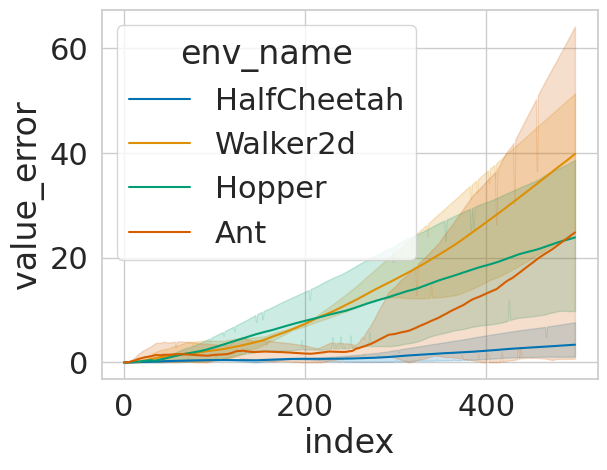

In [76]:
sns.lineplot(data=df_all, x='index', y='value_error', hue='env_name')

In [84]:
df_baselines = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_baselines.csv', index_col=0).reset_index()
df_baselines

index       pred         gt  value_error     env_name data_label  \
0          0  10.205708  10.493137     0.002671  HalfCheetah     expert   
1          1  10.535667  10.967612     0.006684  HalfCheetah     expert   
2          2  11.193826  11.370662     0.008327  HalfCheetah     expert   
3          3  10.803522  10.773823     0.008051  HalfCheetah     expert   
4          4  10.621302  10.444256     0.006406  HalfCheetah     expert   
...      ...        ...        ...          ...          ...        ...   
23947    494   5.965326   5.453143     0.321630          Ant     expert   
23948    495   5.595541   5.463985     0.319179          Ant     expert   
23949    496   5.328989   5.211514     0.316991          Ant     expert   
23950    497   5.259820   5.332366     0.318342          Ant     expert   
23951    498   5.429191   5.329489     0.316485          Ant     expert   

       init_index            algorithm  
0            8000  linreg_pred_actions  
1            8000  linreg_pred_actions  
2            8000  linreg_pred_actions  
3            8000  linreg_pred_actions  
4            8000  linreg_pred_actions  
...           ...                  ...  
23947        5000     mlp_actions_pred  
23948        5000     mlp_actions_pred  
23949        5000     mlp_actions_pred  
23950        5000     mlp_actions_pred  
23951        5000     mlp_actions_pred  

[23952 rows x 8 columns]

In [8]:
df_all = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe.csv', index_col=0).reset_index()
df_all['value_error'] = np.abs(df_all['value_error'])
df_all['algorithm'] = 'llm'
df_all

index       mean     sigma       mode       pred         gt  \
0         0  10.742169  0.470331  10.667021  10.322337  10.820097   
1         1  10.675086  0.417969  10.667021  10.513828  11.599126   
2         2  10.670844  0.452583  10.667021  11.260643  10.783716   
3         3  10.704424  0.513563  10.494679   9.039347  10.512721   
4         4  10.702260  0.550621  10.513828  10.226591  11.321401   
...     ...        ...       ...        ...        ...        ...   
5983    494   6.525875  0.532582   6.429883   6.041249   6.273266   
5984    495   6.994510  0.573396   7.183596   7.360248   5.934760   
5985    496   6.857335  0.466817   6.818516   6.853847   6.041172   
5986    497   6.324610  0.518974   6.194347   5.452411   6.114078   
5987    498   6.646927  0.590836   6.606534   6.677195   6.127858   

      value_error     env_name data_label  init_index algorithm  
0        0.002310  HalfCheetah     expert        4000       llm  
1        0.005929  HalfCheetah     expert        4000       llm  
2        0.006974  HalfCheetah     expert        4000       llm  
3        0.005454  HalfCheetah     expert        4000       llm  
4        0.011386  HalfCheetah     expert        4000       llm  
...           ...          ...        ...         ...       ...  
5983     0.697384          Ant     expert       16000       llm  
5984     0.708390          Ant     expert       16000       llm  
5985     0.726139          Ant     expert       16000       llm  
5986     0.739977          Ant     expert       16000       llm  
5987     0.743641          Ant     expert       16000       llm  

[5988 rows x 11 columns]

In [9]:
df_pca = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_pca.csv', index_col=0).reset_index()
df_pca

index      mean        gt  value_error  env_name data_label  init_index  \
0         0  4.445326  4.530121     0.002358    Hopper     expert       16864   
1         1  4.413515  4.541935     0.005928    Hopper     expert       16864   
2         2  4.427077  4.534075     0.008903    Hopper     expert       16864   
3         3  4.439085  4.482411     0.010108    Hopper     expert       16864   
4         4  4.470719  4.460579     0.009826    Hopper     expert       16864   
...     ...       ...       ...          ...       ...        ...         ...   
1195     95  4.130768  5.447577     0.735482  Walker2d     expert        2000   
1196     96  3.877064  5.490438     0.768254  Walker2d     expert        2000   
1197     97  3.593665  5.590168     0.808808  Walker2d     expert        2000   
1198     98  3.908473  5.584862     0.842860  Walker2d     expert        2000   
1199     99  4.204389  5.463918     0.868445  Walker2d     expert        2000   

          algorithm  
0     $(s,a,r)$-pca  
1     $(s,a,r)$-pca  
2     $(s,a,r)$-pca  
3     $(s,a,r)$-pca  
4     $(s,a,r)$-pca  
...             ...  
1195    $(s,r)$-pca  
1196    $(s,r)$-pca  
1197    $(s,r)$-pca  
1198    $(s,r)$-pca  
1199    $(s,r)$-pca  

[1200 rows x 8 columns]

In [10]:
df_merged = pd.concat([df_all, df_pca], axis=0).drop(['mean', 'sigma', 'mode', 'pred', 'gt', 'data_label'], axis=1)
df_merged

index  value_error     env_name  init_index    algorithm
0         0     0.002310  HalfCheetah        4000          llm
1         1     0.005929  HalfCheetah        4000          llm
2         2     0.006974  HalfCheetah        4000          llm
3         3     0.005454  HalfCheetah        4000          llm
4         4     0.011386  HalfCheetah        4000          llm
...     ...          ...          ...         ...          ...
1195     95     0.735482     Walker2d        2000  $(s,r)$-pca
1196     96     0.768254     Walker2d        2000  $(s,r)$-pca
1197     97     0.808808     Walker2d        2000  $(s,r)$-pca
1198     98     0.842860     Walker2d        2000  $(s,r)$-pca
1199     99     0.868445     Walker2d        2000  $(s,r)$-pca

[7188 rows x 5 columns]

In [295]:
df_all = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe.csv', index_col=0).reset_index()
df_all['value_error'] = np.abs(df_all['value_error'])
df_all['algorithm'] = 'llm'
df_baselines_mbpe = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_baselines.csv', index_col=0).reset_index()
# df_pca = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_pca_extended.csv', index_col=0).reset_index()
df_pca_last_minute = pd.read_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_pca_extended_last_minute.csv', index_col=0).reset_index()

df_list = []
df_list.append(df_all)
df_list.append(df_baselines_mbpe)
df_list.append(df_pca)
# df_list.append(df_pca_last_minute)

df_keep = pd.concat(df_list, axis=0)
df_merged = df_keep.drop(['mean', 'sigma', 'mode', 'pred', 'gt', 'data_label'], axis=1)
df_merged

index  value_error     env_name  init_index    algorithm
0         0     0.002310  HalfCheetah        4000          llm
1         1     0.005929  HalfCheetah        4000          llm
2         2     0.006974  HalfCheetah        4000          llm
3         3     0.005454  HalfCheetah        4000          llm
4         4     0.011386  HalfCheetah        4000          llm
...     ...          ...          ...         ...          ...
5983    494    16.324094  HalfCheetah       16000  $(s,r)$-pca
5984    495    16.368103  HalfCheetah       16000  $(s,r)$-pca
5985    496    16.428895  HalfCheetah       16000  $(s,r)$-pca
5986    497    16.477174  HalfCheetah       16000  $(s,r)$-pca
5987    498    16.531782  HalfCheetah       16000  $(s,r)$-pca

[35928 rows x 5 columns]

In [296]:
df_merged = df_merged.loc[df_merged['algorithm'].isin(['mlp_actions_pred', r'$(s,r)$-pca', r'$(s,a,r)$-pca', 'llm'])]

df_merged.loc[df_merged['algorithm']==r'$(s,r)$-pca', 'algorithm'] = r'ICL-$(s)$-PCA'
df_merged.loc[df_merged['algorithm']==r'$(s,a,r)$-pca', 'algorithm'] = r'ICL-$(s,a)$-PCA'
df_merged.loc[df_merged['algorithm']=='llm', 'algorithm'] = r'vICL'
df_merged.loc[df_merged['algorithm']=='mlp_actions_pred', 'algorithm'] = r'MLP'

<Figure size 640x480 with 0 Axes>

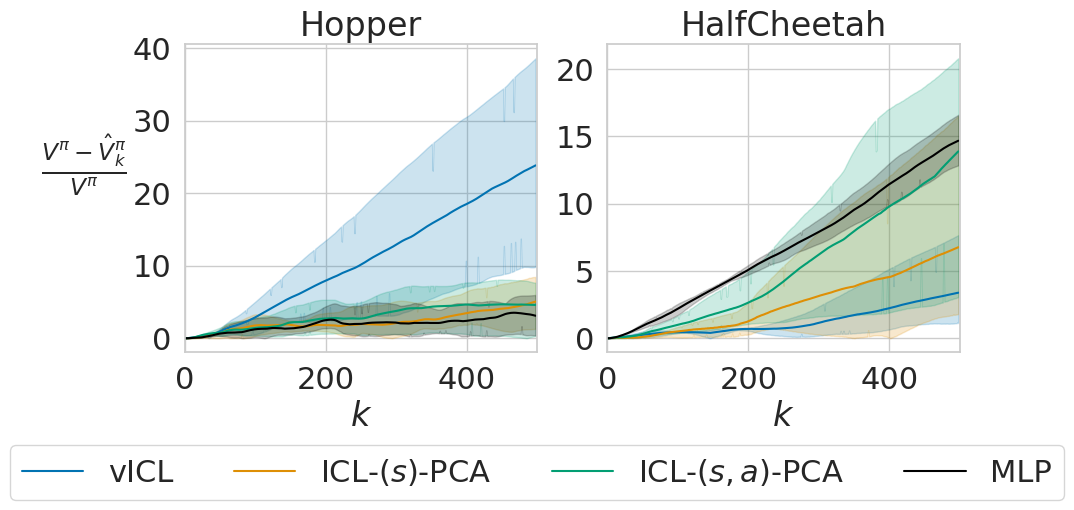

In [298]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

custom_palette = {
    r'vICL': sns.color_palette("colorblind")[0], 
    r'ICL-$(s)$-PCA': sns.color_palette("colorblind")[1], 
    r'ICL-$(s,a)$-PCA': sns.color_palette("colorblind")[2], 
    r'MLP': 'black' # sns.color_palette("colorblind")[7] 
}

# env_name = 'Hopper'
f, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for i, env_name in enumerate(['Hopper', 'HalfCheetah']):
    sns.lineplot(
        data=df_merged.loc[df_merged['env_name']==env_name], 
        x='index', y='value_error', hue='algorithm', hue_order=[r'vICL', r'ICL-$(s)$-PCA', r'ICL-$(s,a)$-PCA', r'MLP'], palette=custom_palette,
        ax=axes[i], legend=False if i>0 else True
    )
    if i == 0:
        axes[i].legend(loc='upper center', bbox_to_anchor=(1.0, -0.25), ncol=6)
        axes[i].set_ylabel(r"$\frac{V^\pi-\hat{V}_k^\pi}{V^\pi}$", rotation=0, labelpad=35)
    else:
        axes[i].set_ylabel(None)
        
    axes[i].set_xlim([0,500])
    # axes[i].set_ylim([0,50])
    axes[i].set_title(env_name)
    axes[i].set_xlabel(r"$k$")
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/ope.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df_keep.loc[(df_keep['env_name']=='Hopper') & (df_keep['init_index']==11864)]

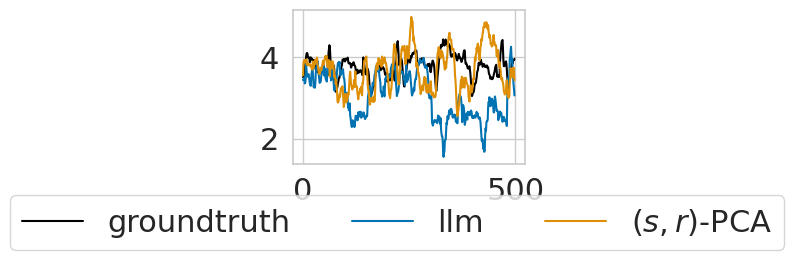

In [123]:
sub_df = df_keep.loc[(df_keep['env_name']=='Hopper') & (df_keep['init_index']==11864)]
plt.figure(figsize=(3,2))
plt.plot(np.arange(499), sub_df['gt'].iloc[:499], color='black', label='groundtruth')
plt.plot(np.arange(499), sub_df.loc[(sub_df['algorithm']=='llm')]['mean'], label='llm')
plt.plot(np.arange(499), sub_df.loc[(sub_df['algorithm']==r'$(s,r)$-pca')]['mean'], label=r'$(s,r)$-PCA')
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.1), ncol=3)
plt.show()